In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.models import Model, Sequential

from keras.regularizers import l2, l1, l1_l2

import omnifold8b as of

import tensorflow as tf




/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4
  tensorflow version:  2.13.1





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]



#--- nominal
resolution = [ 0.5  ]

#--- poor
#resolution = [ 1.0  ]






train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
#-- about 10 seconds
#ngen_train = 10000
#ngen_true =   1000              

                
#-- about 62 seconds
#ngen_train = 100000
#ngen_true =    1000       


#-- about 37  (29 in of8a)  seconds
ngen_train = 100000
ngen_true =   10000

#-- about 47  (38 in of8a)  seconds
#ngen_train = 1000000
#ngen_true =   100000

#-- about 1   (56 seconds) minute
#ngen_train = 2000000
#ngen_true =   200000

#-- about 1:50  (1:48 in of8a)
#ngen_train = 4000000
#ngen_true =   400000

#-- about 5 min
#ngen_train = 10000000
#ngen_true =   1000000







of_niter = 5

#of_niter = 10




#learning_rate_setval = 0.0005
#epochs_setval = 40

#learning_rate_setval = 0.0001
#epochs_setval = 10

#learning_rate_setval = 0.00002
#epochs_setval = 40

#learning_rate_setval = 0.0005
#epochs_setval = 10

#learning_rate_setval = 0.0010
#epochs_setval = 10

#learning_rate_setval = 0.0008
#epochs_setval = 10


#learning_rate_setval = 0.0005
#epochs_setval = 20




learning_rate_setval = 0.0005

#learning_rate_setval = 0.0001

#learning_rate_setval = 0.0010

#learning_rate_setval = 0.0020

#learning_rate_setval = 0.0050






epochs_setval = 400





dropout_setval = 0.0

#dropout_setval = 0.02

#dropout_setval = 0.10

#dropout_setval = 0.20

#dropout_setval = 0.30

#dropout_setval = 0.40





#patience_setval = 5

patience_setval = 25




batch_size_setval = int( ngen_true )

#batch_size_setval = int( ngen_true/10 )

#batch_size_setval = int( ngen_true/100 )



use_batch_norm = False






units_per_layer = 50

#units_per_layer = 10

#units_per_layer = 25

#units_per_layer = 80

#units_per_layer = 40

#units_per_layer = 100



number_of_layers = 3

#number_of_layers = 2



output_dir = 'toy-study8b-inspect-of-1d-2a'

save_step2_model = True





 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100


In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()



 Output directory already exists:  toy-study8b-inspect-of-1d-2a


In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [12]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )


true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights


In [13]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )


config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : toy-study8b-inspect-of-1d-2a/config.txt

2024-07-15 09:27:21.218970

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       1
learning_rate_setval  0.000500
epochs_setval  400
batch_size_setval  10000


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.5]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

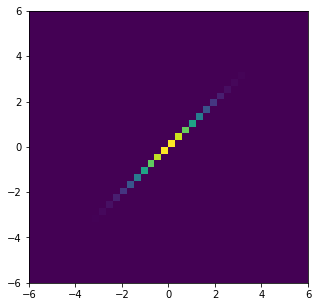

In [16]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

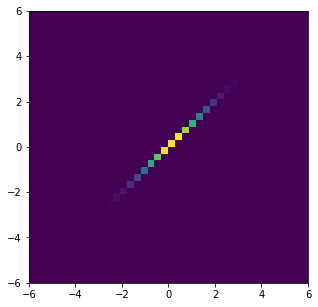

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

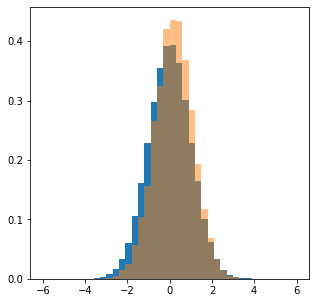

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [19]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[-0.93240556]
 [-1.39581657]
 [-0.96793234]
 ...
 [ 0.69501446]
 [ 1.01530654]
 [ 1.08795601]]


In [20]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-1.13240556]
 [-1.59581657]
 [-1.16793234]
 ...
 [ 0.49501446]
 [ 0.81530654]
 [ 0.88795601]]


In [21]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [22]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [23]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [24]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [25]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [26]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [27]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [28]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [29]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.36529318 0.21298855 0.35316799 ... 0.44313204 0.33696082 0.31217571]


In [30]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.28405887 0.13015899 0.27008449 ... 0.53887952 0.41589255 0.3853082 ]


In [31]:
pdf_ratio = pdf_true / pdf_train

In [32]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [33]:
calc_weight = pdf_ratio

In [34]:
calc_weight_scaled = sample_sf * pdf_ratio

## Set up NN model for OmniFold

In [35]:

import tensorflow.keras.backend as K


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

In [36]:


from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=patience_setval,
               verbose=True,
               restore_best_weights=True)




#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)




#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#drop1 = Dropout(dropout_setval)(hidden_layer_1)
#hidden_layer_2 = Dense(50, activation='relu')(drop1)
#drop2 = Dropout(dropout_setval)(hidden_layer_2)
#hidden_layer_3 = Dense(50, activation='relu')(drop2)
#drop3 = Dropout(dropout_setval)(hidden_layer_3)
#outputs = Dense(1, activation='sigmoid')(drop3)



#model_step1 = Model(inputs=inputs, outputs=outputs)
#model_step2 = Model(inputs=inputs, outputs=outputs)


###================================

#model_step1 = Sequential()

#model_step1.add( Dense(50, input_dim=ndim, activation='relu') )
#model_step1.add( Dropout(dropout_setval) )
#model_step1.add( Dense(50, activation='relu') )
#model_step1.add( Dropout(dropout_setval) )
#model_step1.add( Dense(50, activation='relu') )
#model_step1.add( Dropout(dropout_setval) )
#model_step1.add( Dense(1, activation='sigmoid') )


#model_step2 = Sequential()

#model_step2.add( Dense(50, input_dim=ndim, activation='relu') )
#model_step2.add( Dropout(dropout_setval) )
#model_step2.add( Dense(50, activation='relu') )
#model_step2.add( Dropout(dropout_setval) )
#model_step2.add( Dense(50, activation='relu') )
#model_step2.add( Dropout(dropout_setval) )
#model_step2.add( Dense(1, activation='sigmoid') )

###================================



#-- off
l2reg_setval = 0.0

#-- crap
#l2reg_setval = 0.001

#-- not crap
#l2reg_setval = 0.0001

#-- not crap
#l2reg_setval = 0.00001

#-- not crap
#l2reg_setval = 0.000001

#-- not crap
#l2reg_setval = 0.0000001





#-- off
al2reg_setval = 0.0

#-- not crap
#al2reg_setval = 0.0001

#-- not crap
#al2reg_setval = 0.00001

#-- not crap
#al2reg_setval = 0.000001

#-- not crap
#al2reg_setval = 0.0000001

#-- not crap
#al2reg_setval = 0.001

#-- not crap but a bit too strong
#al2reg_setval = 0.01



model_step1 = Sequential()

model_step1.add( Dense(units_per_layer, input_dim=ndim, activation='relu', 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
if use_batch_norm : model_step1.add( BatchNormalization() )
model_step1.add( Dropout(dropout_setval) )

if number_of_layers > 1 :
    model_step1.add( Dense(units_per_layer, activation='relu', 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

if number_of_layers > 2 :
    model_step1.add( Dense(units_per_layer, activation='relu', 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

model_step1.add( Dense(1, activation='sigmoid') )





model_step2 = Sequential()

model_step2.add( Dense(units_per_layer, input_dim=ndim, activation='relu', 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
if use_batch_norm : model_step2.add( BatchNormalization() )
model_step2.add( Dropout(dropout_setval) )

if number_of_layers > 1 :
    model_step2.add( Dense(units_per_layer, activation='relu', 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

if number_of_layers > 2 :
    model_step2.add( Dense(units_per_layer, activation='relu', 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

model_step2.add( Dense(1, activation='sigmoid') )


#----








#----


#-- off
#l1reg_setval = 0.0

#-- crap
#l1reg_setval = 0.001

#-- 
#l1reg_setval = 0.0001

#-- not crap but slow
#l1reg_setval = 0.00001

#-- may be doing nothing
#l1reg_setval = 0.000001



#-- off
#al1reg_setval = 0.0

#-- may be doing nothing
#al1reg_setval = 0.00001

#-- closure not great 
#al1reg_setval = 0.0001

#-- crap
#al1reg_setval = 0.001




#model_step1 = Sequential()

#model_step1.add( Dense(50, input_dim=ndim, activation='relu', 
#                       kernel_regularizer=l1(l1reg_setval), 
#                       bias_regularizer=l1(l1reg_setval), 
#                       activity_regularizer=l1(al1reg_setval) ) )
#model_step1.add( Dropout(dropout_setval) )
#model_step1.add( Dense(50, activation='relu', 
#                       kernel_regularizer=l1(l1reg_setval), 
#                       bias_regularizer=l1(l1reg_setval), 
#                       activity_regularizer=l1(al1reg_setval) ) )
#model_step1.add( Dropout(dropout_setval) )
#model_step1.add( Dense(50, activation='relu', 
#                       kernel_regularizer=l1(l1reg_setval), 
#                       bias_regularizer=l1(l1reg_setval), 
#                       activity_regularizer=l1(al1reg_setval) ) )
#model_step1.add( Dropout(dropout_setval) )
#model_step1.add( Dense(1, activation='sigmoid') )


#model_step2 = Sequential()

#model_step2.add( Dense(50, input_dim=ndim, activation='relu', 
#                       kernel_regularizer=l1(l1reg_setval), 
#                       bias_regularizer=l1(l1reg_setval), 
#                       activity_regularizer=l1(al1reg_setval) ) )
#model_step2.add( Dropout(dropout_setval) )
#model_step2.add( Dense(50, activation='relu', 
#                       kernel_regularizer=l1(l1reg_setval), 
#                       bias_regularizer=l1(l1reg_setval), 
#                       activity_regularizer=l1(al1reg_setval) ) )
#model_step2.add( Dropout(dropout_setval) )
#model_step2.add( Dense(50, activation='relu', 
#                       kernel_regularizer=l1(l1reg_setval), 
#                       bias_regularizer=l1(l1reg_setval), 
#                       activity_regularizer=l1(al1reg_setval) ) )
#model_step2.add( Dropout(dropout_setval) )
#model_step2.add( Dense(1, activation='sigmoid') )

#----









opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

model_step1.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step1,
                      metrics=['accuracy'])

model_step2.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step2,
                      metrics=['accuracy'])

print('\n\n ------ model_step1:')
model_step1.summary()

print('\n\n ------ model_step2:')
model_step2.summary()



 ------ model_step1:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (Non

## Package the training data for OmniFold

In [37]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [38]:
%%time


#verbose = True
verbose = False






of_return_dict = of.omnifold8b( 
    train_both, true_det_pts, of_niter, model_step1, model_step2, verbose, 
    batch_size_setval, epochs_setval,
    save_step2_model, output_dir,
    patience_setval
)

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
10/10 [==============================] - 0s 717us/step
Restoring model weights from the end of the best epoch: 272.
Epoch 297: early stopping
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in toy-study8b-inspect-of-1d-2a/of-step2-iter00-model
INFO:tensorflow:Assets written to: toy-study8b-inspect-of-1d-2a/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: toy-study8b-inspect-of-1d-2a/of-step2-iter00-model/assets


 weights_push at the beginning
[0.80850685 0.68090057 0.79793012 ... 1.15113616 1.15501332 1.15289807]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
10/10 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in toy-study8b-inspect-of-1d-2a/of-step2-iter01-model
INFO:tensorflow:Assets written to: toy-study8b-inspect-of-1d-2a/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: toy-study8b-inspect-of-1d-2a/of-step2-iter01-model/assets


 weights_push at the beginning
[0.76980745 0.6116005  0.75638431 ... 1.21049936 1.20943339 1.2041406 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
10/10 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in toy-study8b-inspect-of-1d-2a/of-step2-iter02-model
INFO:tensorflow:Assets written to: toy-study8b-inspect-of-1d-2a/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: toy-study8b-inspect-of-1d-2a/of-step2-iter02-model/assets


 weights_push at the beginning
[0.77425261 0.60460782 0.76008553 ... 1.23686549 1.23314251 1.22719374]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
10/10 [==============================] - 0s 702us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in toy-study8b-inspect-of-1d-2a/of-step2-iter03-model
INFO:tensorflow:Assets written to: toy-study8b-inspect-of-1d-2a/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: toy-study8b-inspect-of-1d-2a/of-step2-iter03-model/assets


 weights_push at the beginning
[0.77544528 0.59621816 0.76068346 ... 1.24683932 1.23690914 1.22963376]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
10/10 [==============================] - 0s 692us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in toy-study8b-inspect-of-1d-2a/of-step2-iter04-model
INFO:tensorflow:Assets written to: toy-study8b-inspect-of-1d-2a/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: toy-study8b-inspect-of-1d-2a/of-step2-iter04-model/assets


CPU times: user 51.1 s, sys: 9.76 s, total: 1min
Wall time: 40.5 s


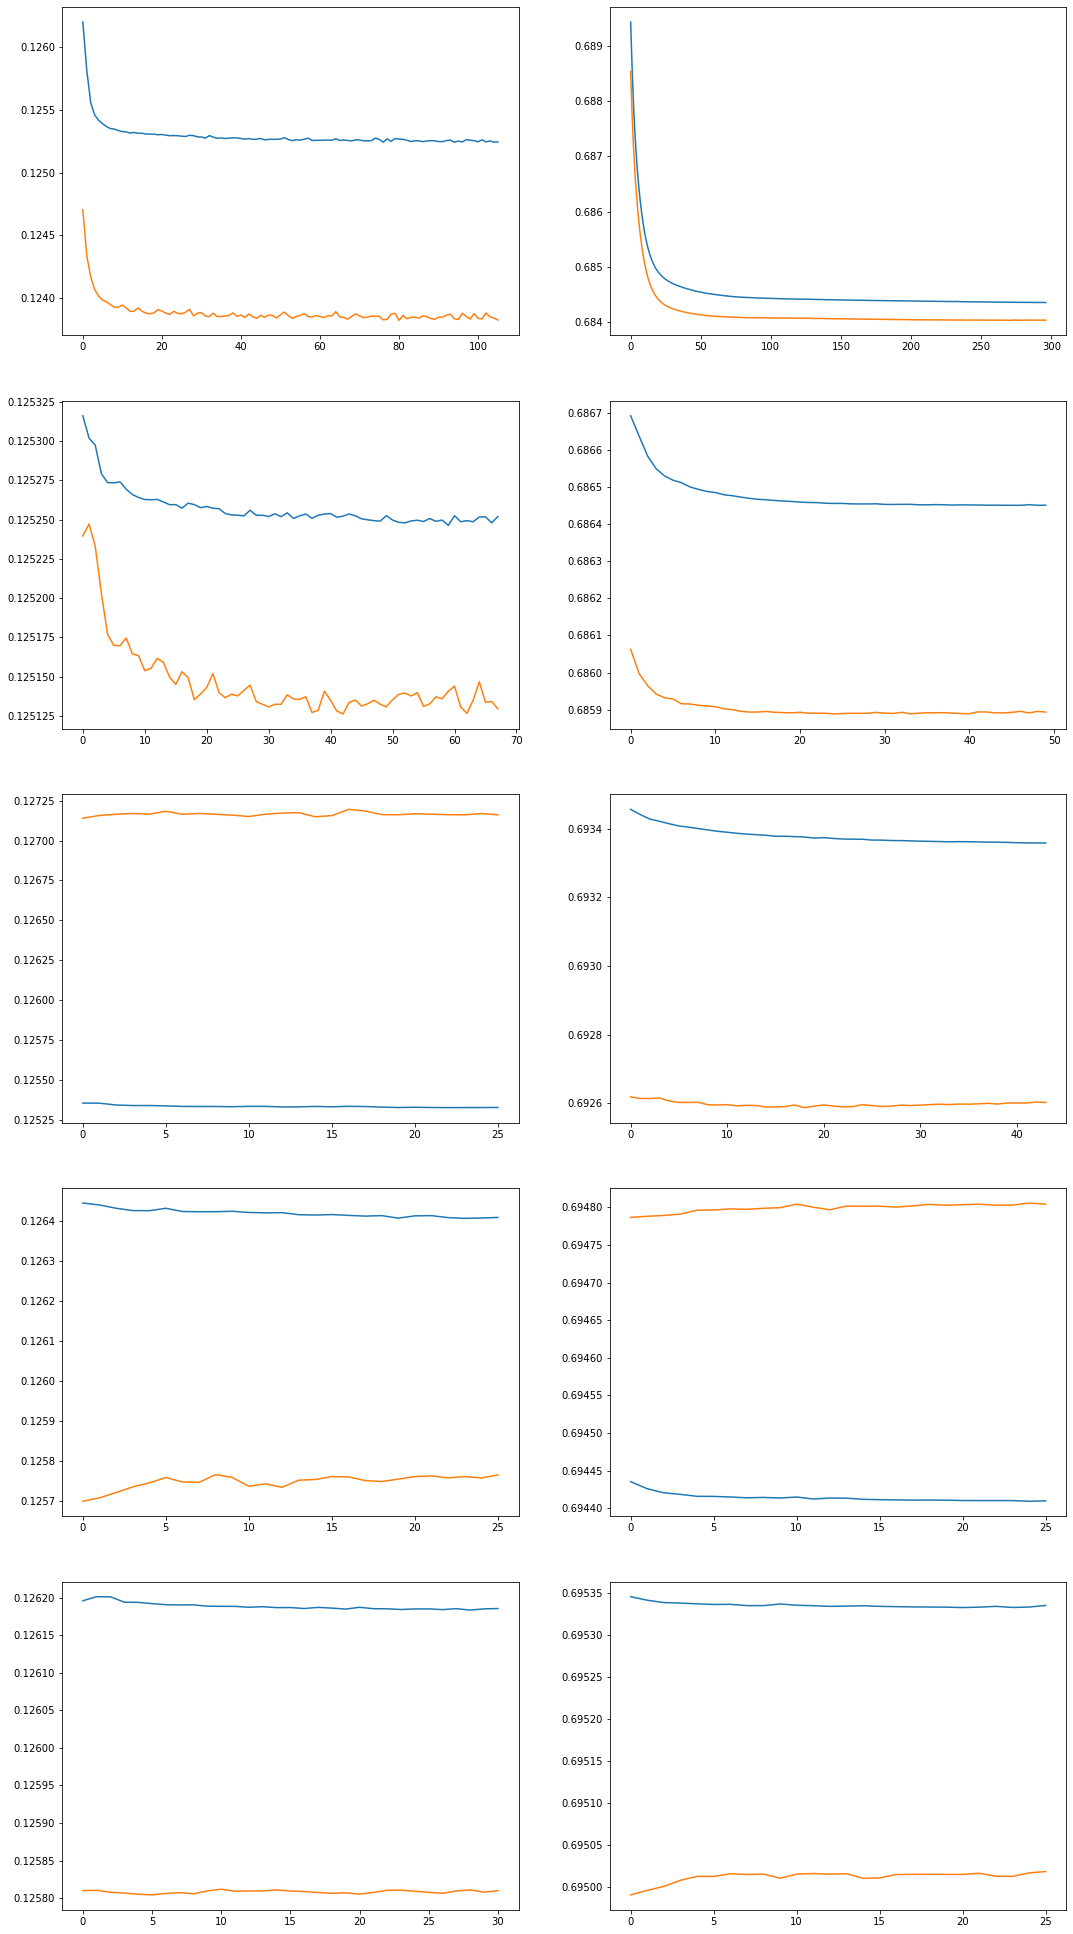

In [39]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

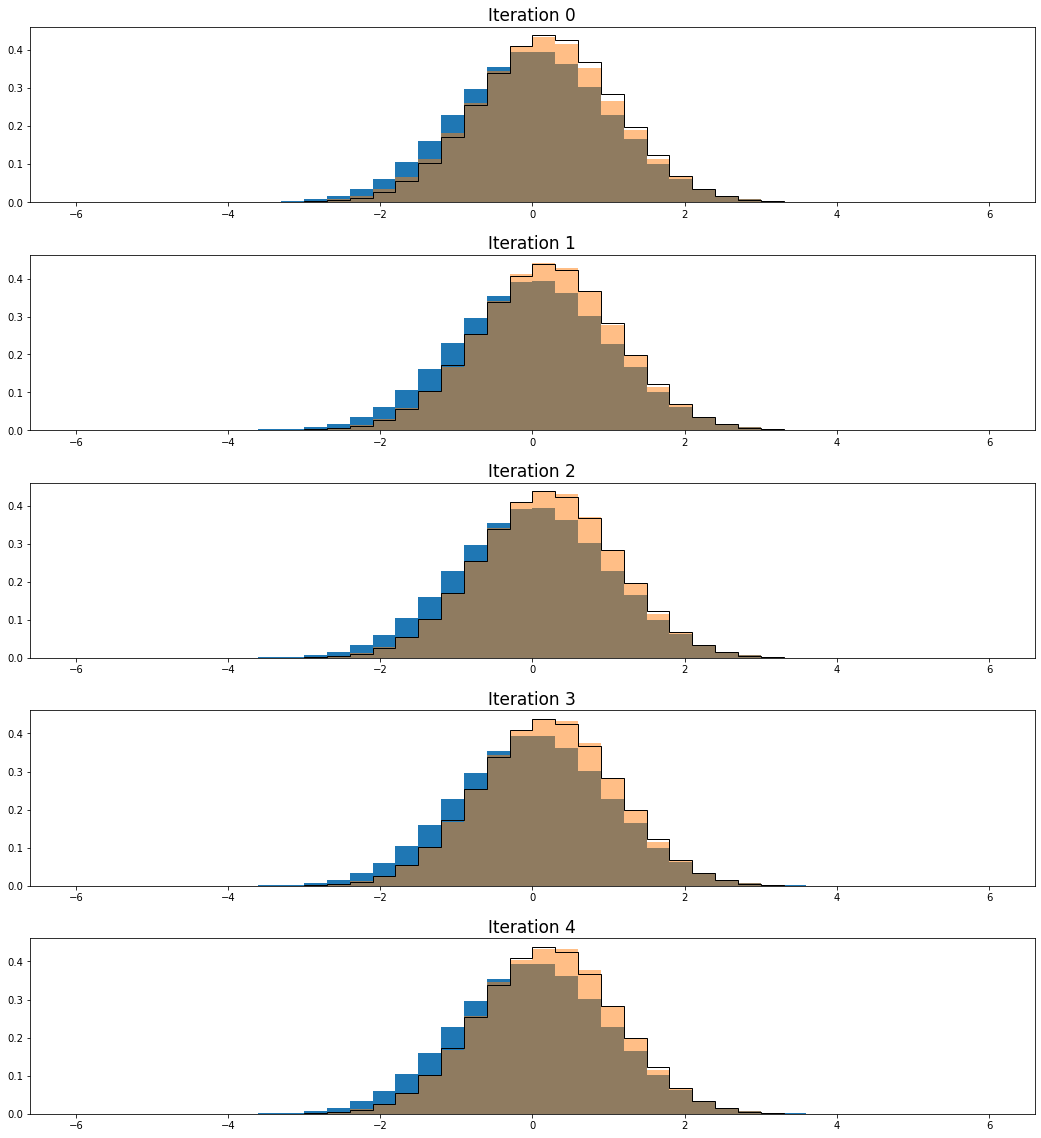

In [40]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [41]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

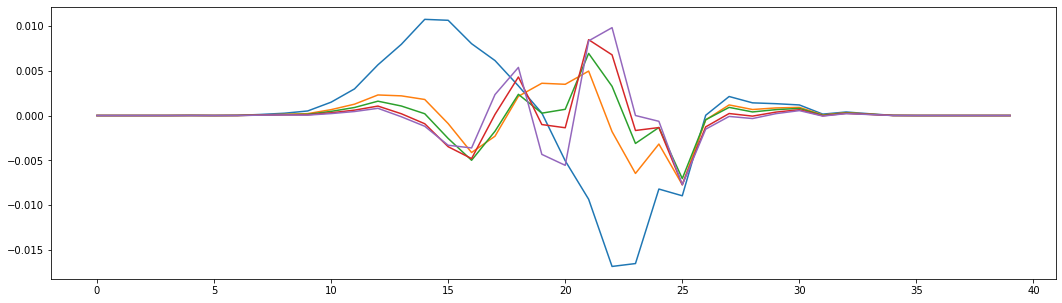

In [42]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

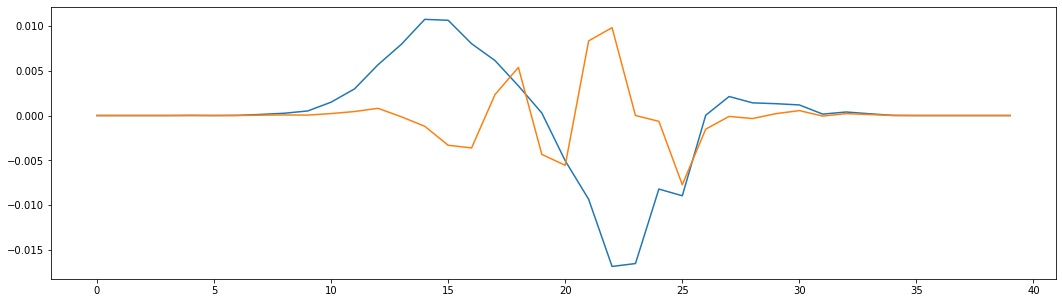

In [43]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

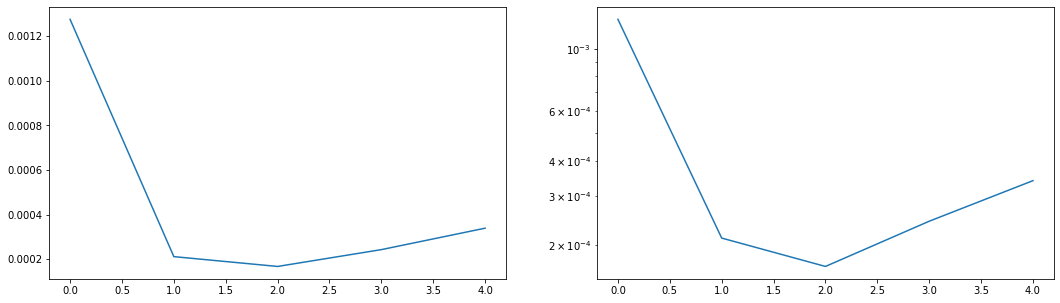

In [44]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

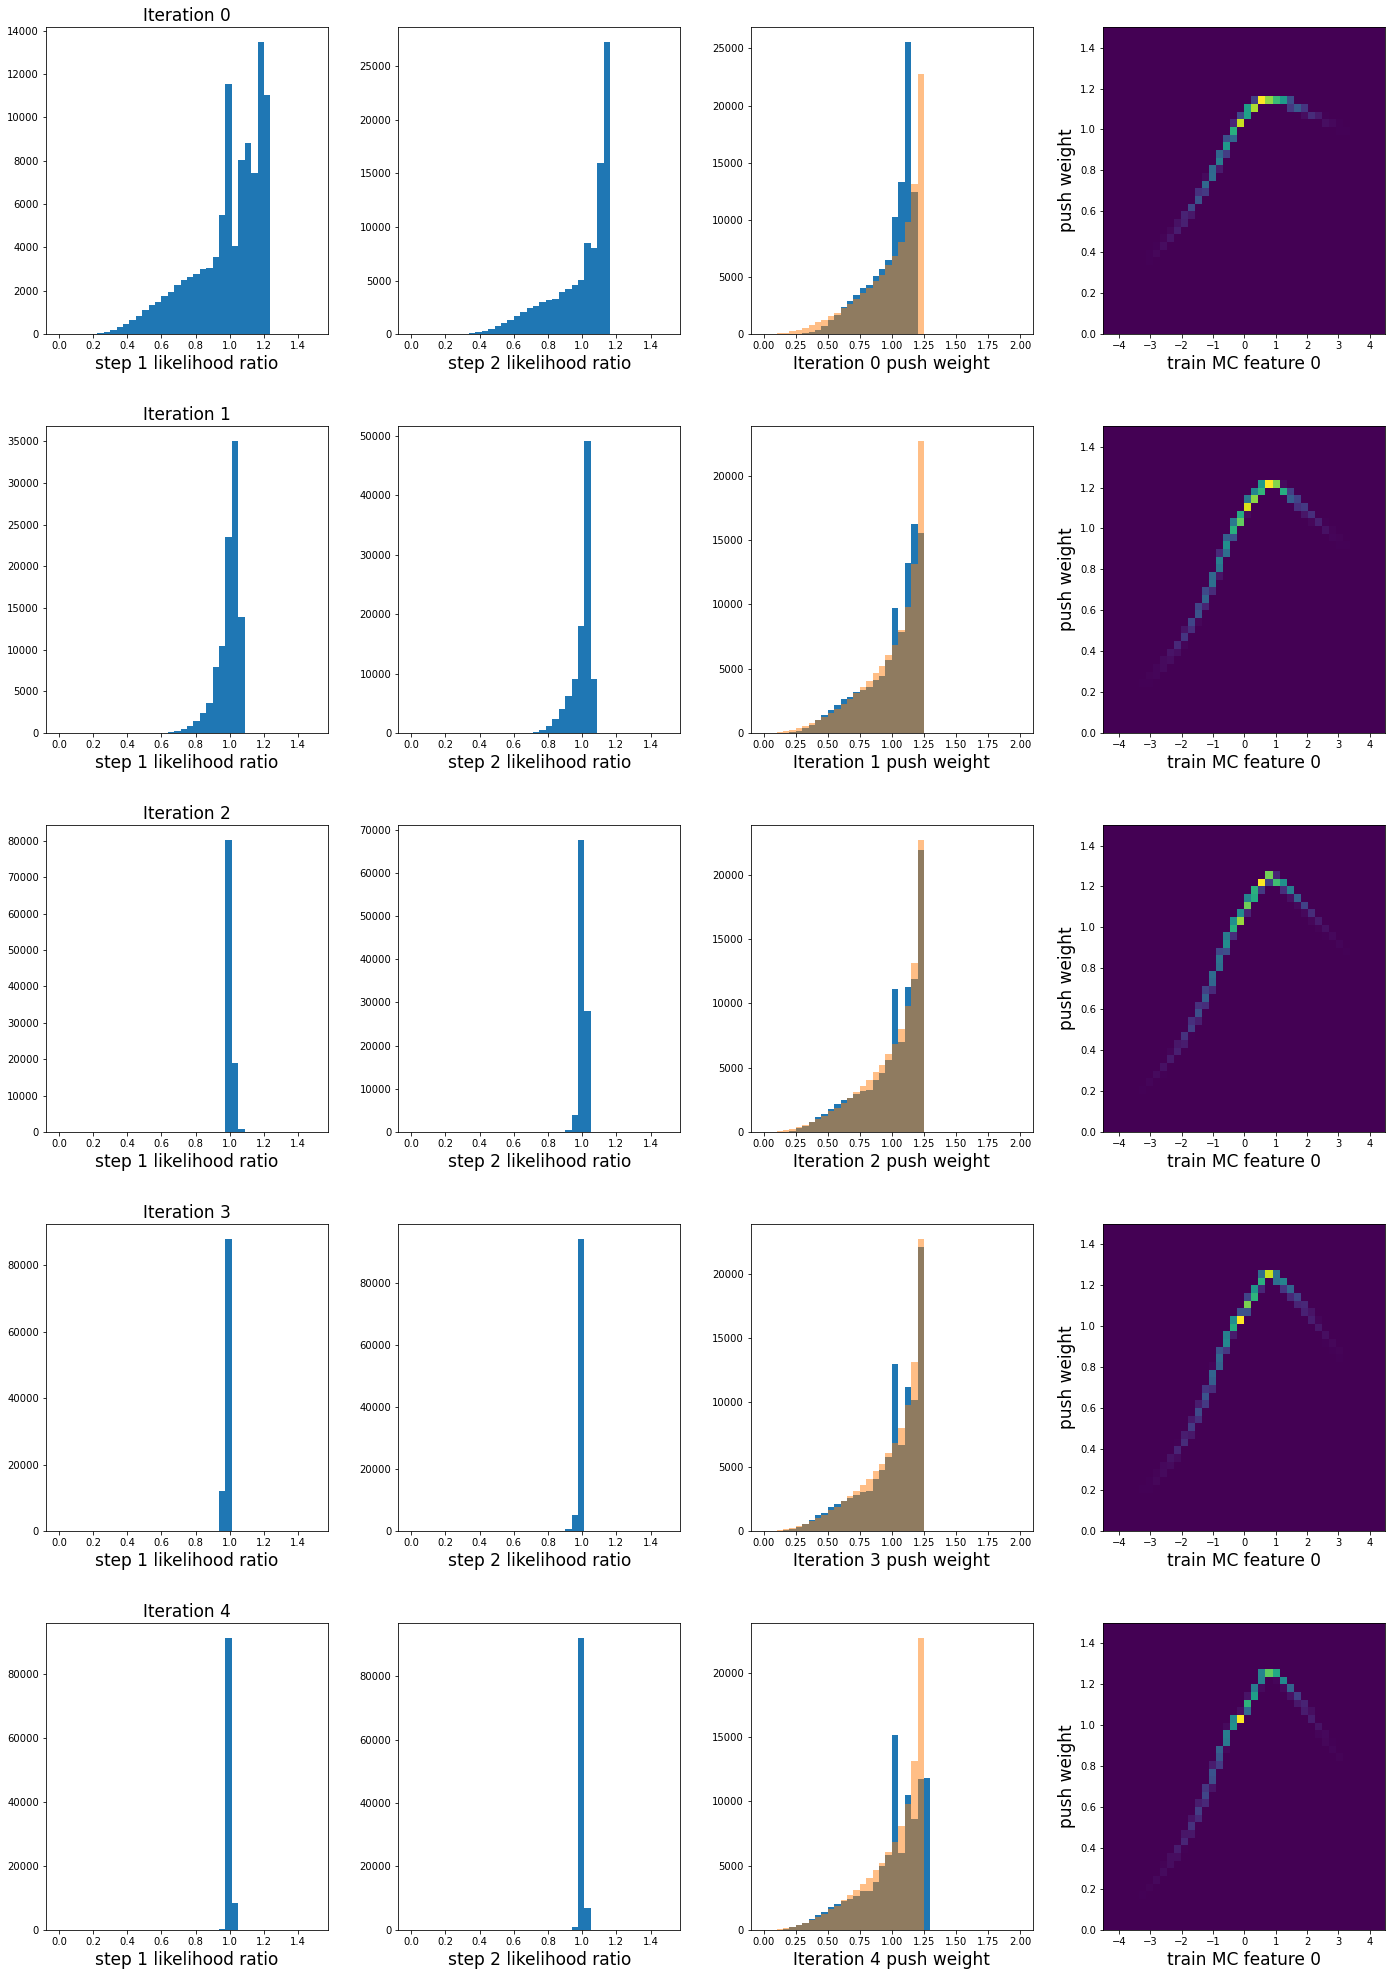

In [45]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    #ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )

    ax[ofi][3].hist2d( train_pts[:,0], push_weights[ofi,:], 
                      bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )
    
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    #ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    #ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    
    ax[ofi][3].set_xlabel( 'train MC feature 0' , fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'push weight' , fontsize=lfontsize )
    
    
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

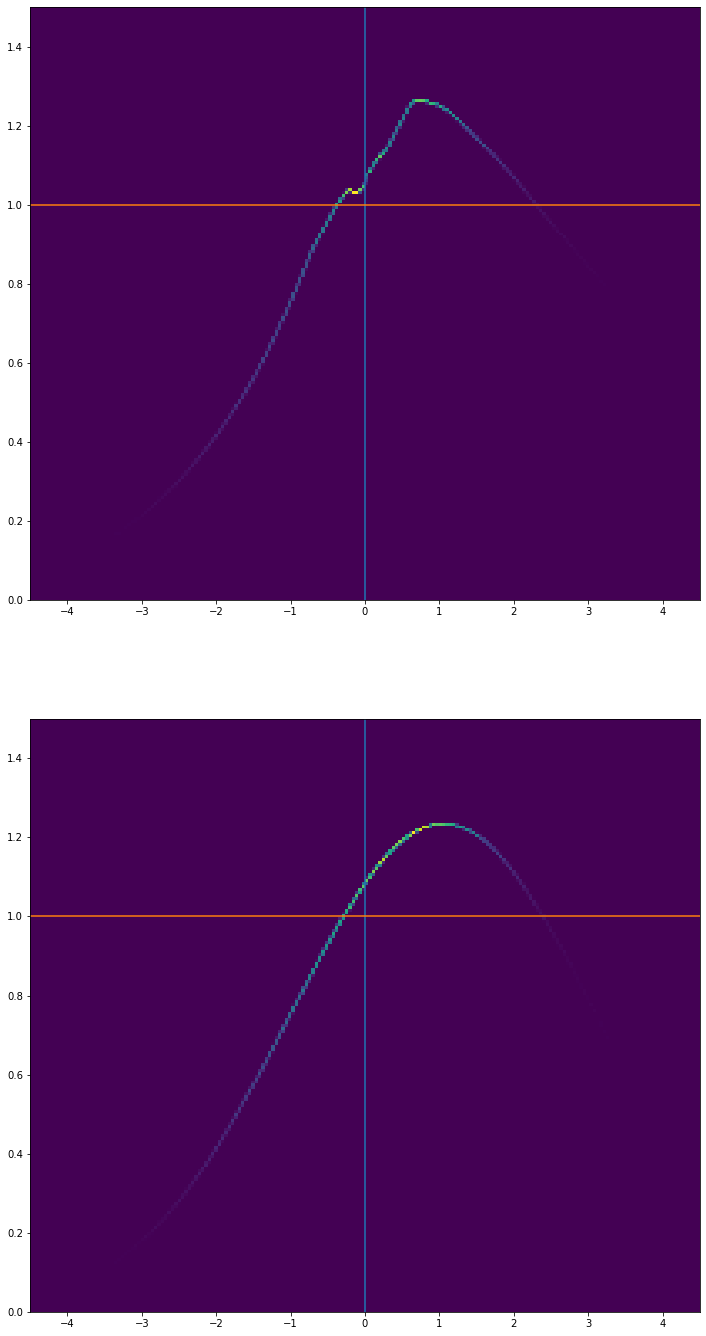

In [46]:
fig,ax = plt.subplots( 2, 1, figsize=(12,2*12))

hbins=200

hpw,_,_,_ = ax[0].hist2d( train_pts[:,0], push_weights[-1,:], 
                      bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )

hcw,_,_,_ = ax[1].hist2d( train_pts[:,0], calc_weight, 
                      bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )

ax[0].plot([0,0],[0,1.5])
ax[0].plot([-4.5,4.5],[1,1])

ax[1].plot([0,0],[0,1.5])
ax[1].plot([-4.5,4.5],[1,1])

plt.show

In [47]:
fpw = np.zeros( hpw.shape[0])

for bi0 in range(hpw.shape[0]) :
    esum = 0
    biesum = 0    
    for bi1 in range(hpw.shape[1]) :
        esum += hpw[bi0,bi1]
        biesum += bi1*hpw[bi0,bi1]
        #print(' %3d, %3d :  %8.0f    %8.0f  %8.0f' % (bi0, bi1, hpw[bi1,bi0], esum, biesum))
    wave = 0
    if esum > 0 :
        wave = biesum / esum
    fpw[bi0] = wave
    #print(' %3d : %8.3f' % (bi0, wave))

In [48]:
fcw = np.zeros( hcw.shape[0])

for bi0 in range(hcw.shape[0]) :
    esum = 0
    biesum = 0    
    for bi1 in range(hcw.shape[1]) :
        esum += hcw[bi0,bi1]
        biesum += bi1*hcw[bi0,bi1]
    wave = 0
    if esum > 0 :
        wave = biesum / esum
    fcw[bi0] = wave


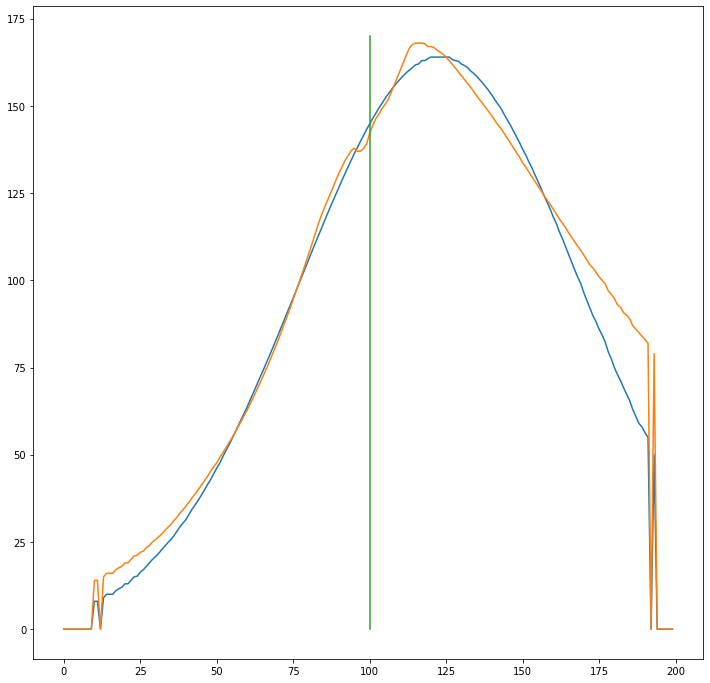

In [49]:
fig,ax = plt.subplots( 1, 1, figsize=(12,12))
ax.plot(fcw)
ax.plot(fpw)
ax.plot([100,100],[0,170])

<function matplotlib.pyplot.show(close=None, block=None)>

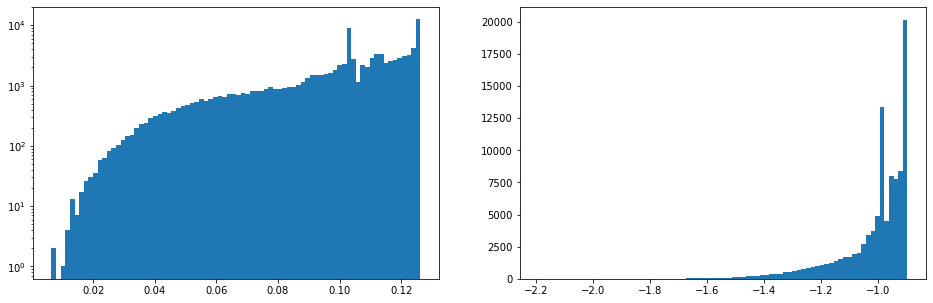

In [50]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

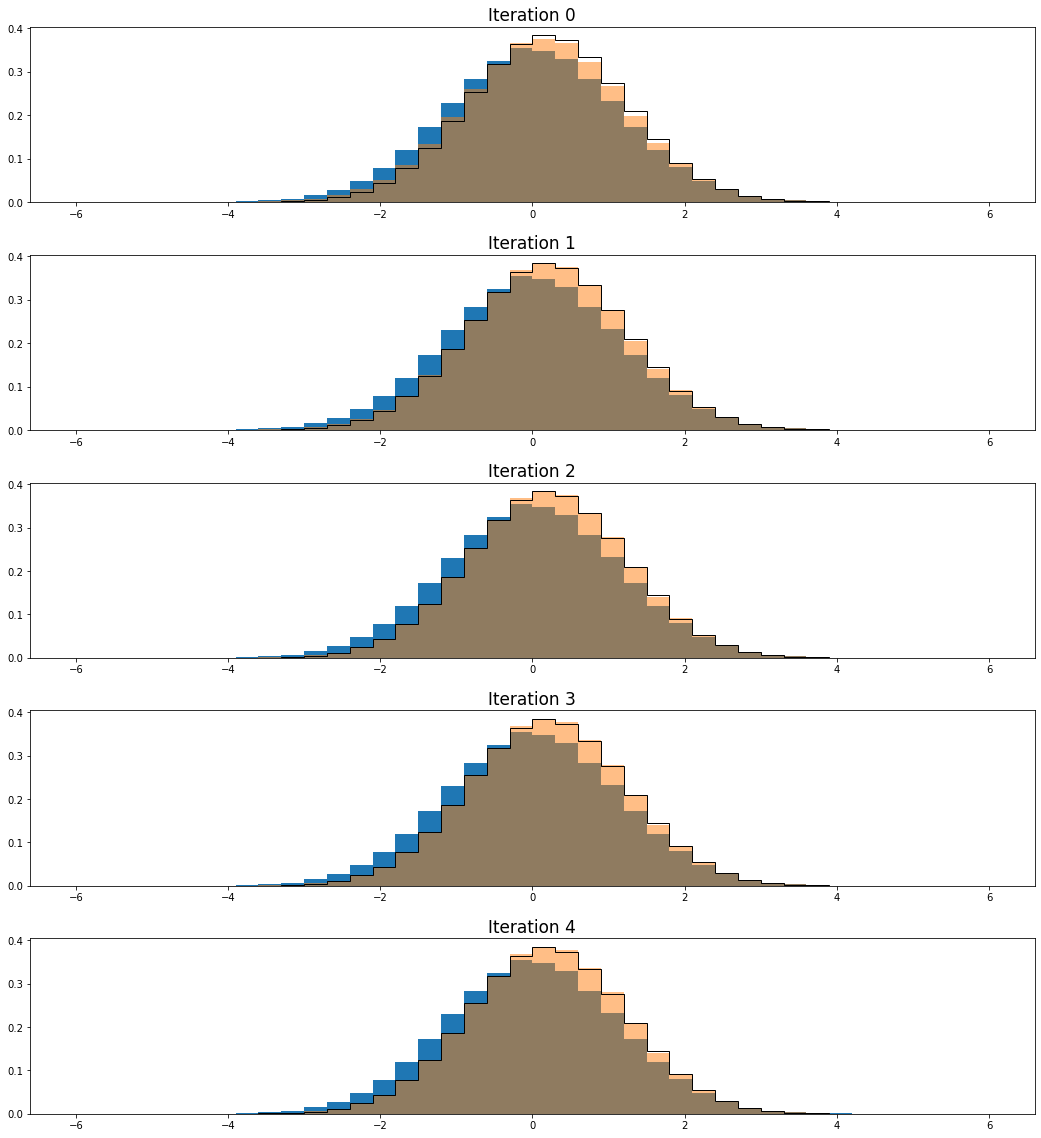

In [51]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [52]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

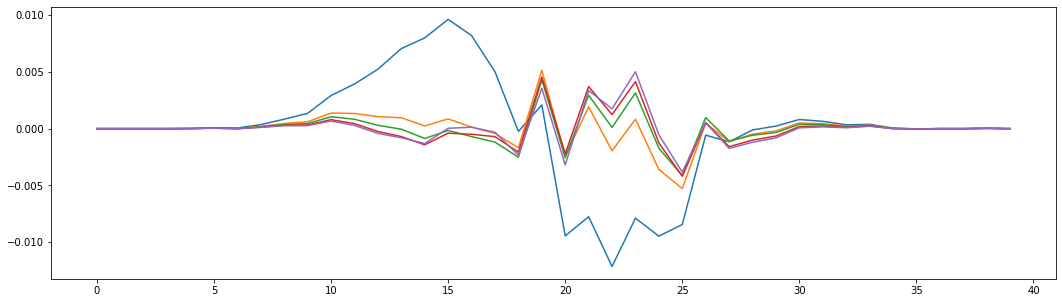

In [53]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

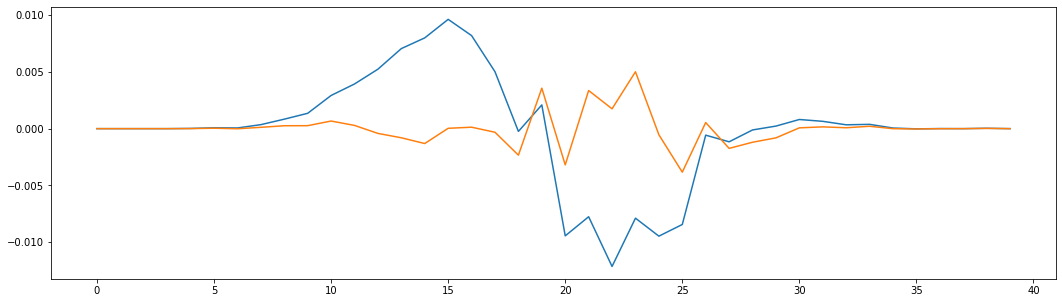

In [54]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

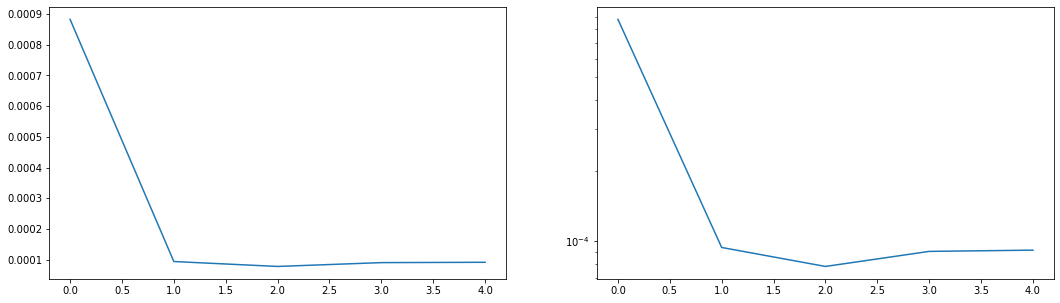

In [55]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [56]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  0.988  rms 0.206      step 2 mean  0.989  rms 0.177
  iter  1 : step 1 mean  0.994  rms 0.065      step 2 mean  0.998  rms 0.059
  iter  2 : step 1 mean  1.006  rms 0.012      step 2 mean  1.005  rms 0.015
  iter  3 : step 1 mean  0.994  rms 0.014      step 2 mean  0.996  rms 0.012
  iter  4 : step 1 mean  1.004  rms 0.007      step 2 mean  1.003  rms 0.009


<function matplotlib.pyplot.show(close=None, block=None)>

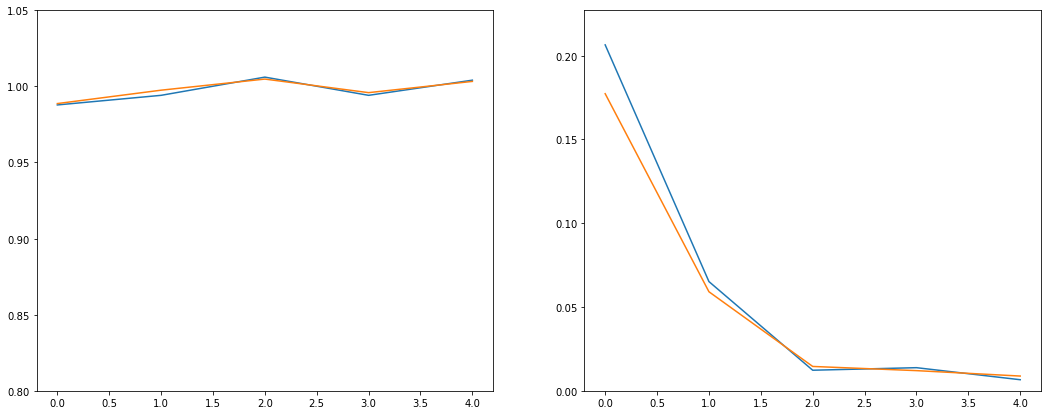

In [57]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

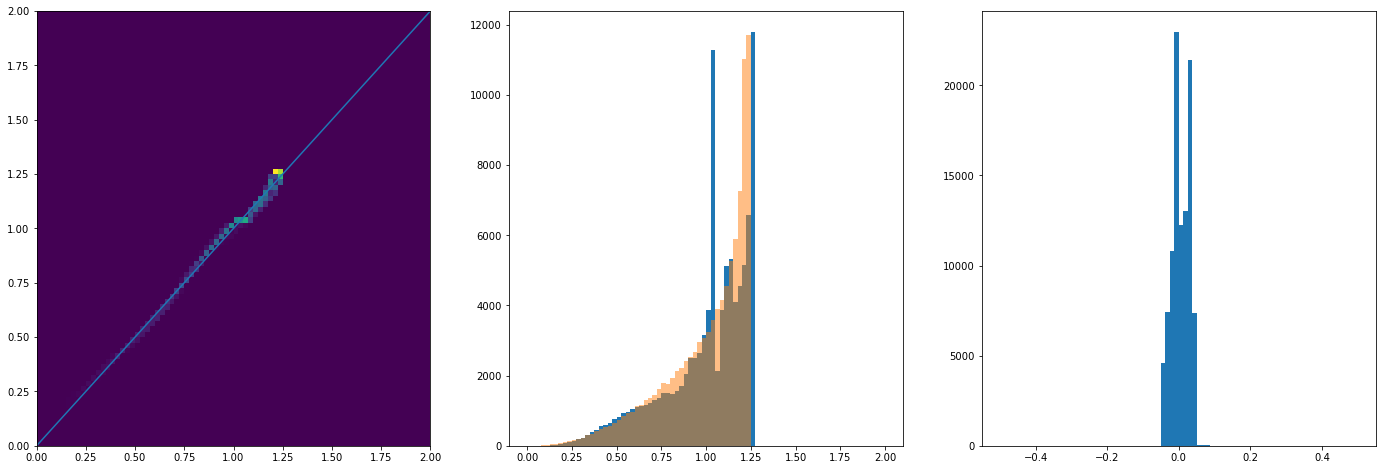

In [58]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [59]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.02413




## Monitoring of the OmniFold internal details

In [60]:
def profile2d( axis, xvals, yvals, hbins, hrange, drawhist=True, drawline=False ) :
    
    hist_data = axis.hist2d( xvals, yvals, bins=hbins, range=hrange)
    
    if not drawhist :
        axis.cla()

    nybins = len(hist_data[0][0])
    print("number of y bins: %d" % nybins)

    nxbins = len(hist_data[0])
    print("number of x bins: %d" % nxbins)



    x_vals = np.zeros( nxbins )
    avey_vals = np.zeros( nxbins )
    rmsy_vals = np.zeros( nxbins )

    for xbi in range( nxbins ) :

        wsum = 0
        ywsum = 0
        yywsum = 0

        xval = 0.5 * ( hist_data[1][xbi] + hist_data[1][xbi+1] )
        #print(" xbin %d has center at %6.3f" % ( xbin_ind, xval ))

        for ybi in range( nybins ) :  
            yval = 0.5 * ( hist_data[2][ybi] + hist_data[2][ybi+1] )
            bin_content = hist_data[0][xbi][ybi]
            wsum = wsum + bin_content
            ywsum = ywsum + yval * bin_content
            yywsum = yywsum + yval * yval * bin_content
            #print("  %3d : y = %6.3f  bin content = %7d" % (bi, yval, bin_content))

        ave_y = ywsum / wsum
        ave_yy = yywsum / wsum
        rms_y = ave_yy - ave_y * ave_y
        #print(" Ave y = %.3f, RMS y = %.3f" % ( ave_y, rms_y) )

        x_vals[xbi] = xval
        avey_vals[xbi] = ave_y
        rmsy_vals[xbi] = rms_y


    #for xbi in range( nxbins ) :
        #print("  %4d :  x = %7.3f   ave y = %7.3f  rms y = %7.3f" % ( xbi, x_vals[xbi], avey_vals[xbi], rmsy_vals[xbi]))

    if drawline :
        axis.plot( (hist_data[1][0], hist_data[1][-1]), (0,0) )  
    
    axis.errorbar( x_vals, avey_vals, yerr=rmsy_vals, fmt='-', linewidth=5)

    
    plt.show
    

In [61]:
of_return_dict

{'train-hist-step1-iter0': <keras.callbacks.History at 0x7cc03c15a0e0>,
 'train-hist-step2-iter0': <keras.callbacks.History at 0x7cbfe42881f0>,
 'train-hist-step1-iter1': <keras.callbacks.History at 0x7cbf9c65b460>,
 'train-hist-step2-iter1': <keras.callbacks.History at 0x7cbf9c4b09d0>,
 'train-hist-step1-iter2': <keras.callbacks.History at 0x7cbf9c4a3760>,
 'train-hist-step2-iter2': <keras.callbacks.History at 0x7cc0039c0a60>,
 'train-hist-step1-iter3': <keras.callbacks.History at 0x7cbf9c1ffd00>,
 'train-hist-step2-iter3': <keras.callbacks.History at 0x7cbf9c6ec7c0>,
 'train-hist-step1-iter4': <keras.callbacks.History at 0x7cbf7c5254b0>,
 'train-hist-step2-iter4': <keras.callbacks.History at 0x7cbfe42a56f0>,
 'weights': array([[[0.81307095, 0.78900868, 0.62856501, ..., 1.13148081,
          1.19427013, 1.1221329 ],
         [0.80850685, 0.68090057, 0.79793012, ..., 1.15113616,
          1.15501332, 1.15289807]],
 
        [[0.95063448, 0.94470644, 0.89270931, ..., 1.0259732 ,
       

In [62]:
of_return_dict['weights'].shape

(5, 2, 100000)

In [63]:
of_return_dict['weights'][0,1,:]

array([0.80850685, 0.68090057, 0.79793012, ..., 1.15113616, 1.15501332,
       1.15289807])

In [64]:
of_return_dict['push_weights'][0]

array([0.80850685, 0.68090057, 0.79793012, ..., 1.15113616, 1.15501332,
       1.15289807])

In [65]:
train_pts[:,0].shape

(100000,)

In [66]:
of_prob = of_return_dict['weights'] / (1. + of_return_dict['weights'] )

In [67]:
of_prob

array([[[0.44844961, 0.44103122, 0.38596249, ..., 0.5308426 ,
         0.5442676 , 0.52877598],
        [0.44705766, 0.40508081, 0.44380486, ..., 0.53512938,
         0.53596575, 0.53550983]],

       [[0.48734629, 0.48578357, 0.47165685, ..., 0.50641006,
         0.51419569, 0.50691813],
        [0.48774027, 0.47319148, 0.48663533, ..., 0.51256824,
         0.51150799, 0.51087011]],

       [[0.49892312, 0.49846422, 0.49878061, ..., 0.50069236,
         0.50400252, 0.50751771],
        [0.50143944, 0.49712521, 0.50122034, ..., 0.50538664,
         0.5048533 , 0.50474084]],

       [[0.49469243, 0.49454319, 0.49307337, ..., 0.50193858,
         0.5015558 , 0.50206204],
        [0.50038481, 0.49650671, 0.50019659, ..., 0.50200785,
         0.50076246, 0.50049658]],

       [[0.5013829 , 0.50133686, 0.50172276, ..., 0.50071866,
         0.50095498, 0.49843396],
        [0.50296955, 0.5010069 , 0.50289209, ..., 0.50315666,
         0.50246977, 0.50232124]]])

number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


<function matplotlib.pyplot.show(close=None, block=None)>

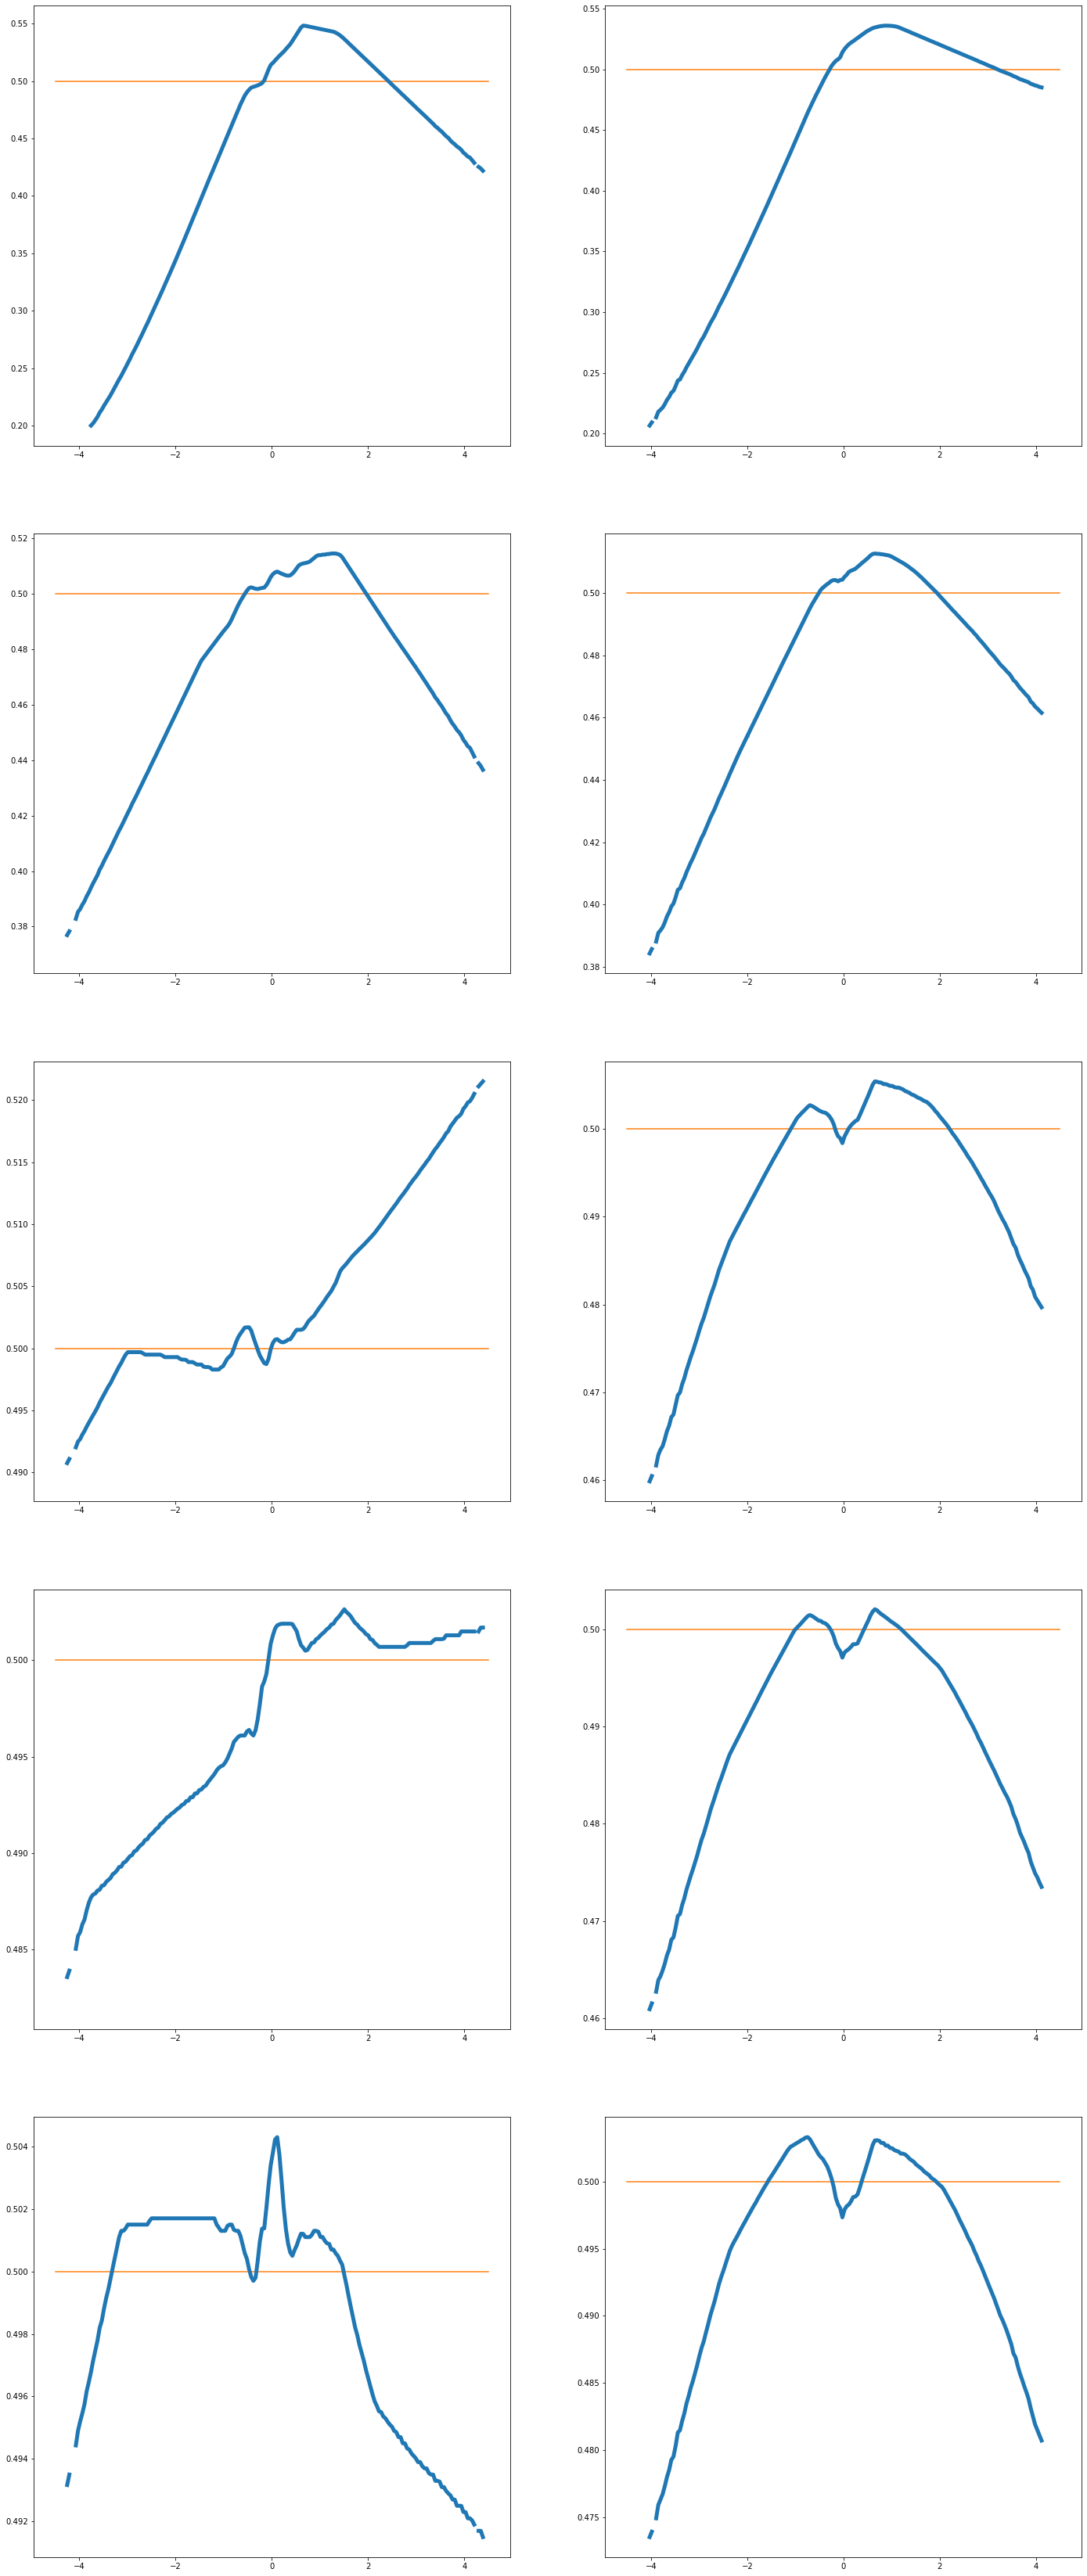

In [68]:
fig,ax = plt.subplots( of_niter, 2, figsize=(2*12,of_niter*12))

xmin = -4.5
xmax = 4.5

ymin = 0.2
ymax = 0.6

for ofi in range( of_niter ) :

    profile2d( ax[ofi][0], train_det_pts[:,0], of_prob[ofi,0,:], 
          hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
    ax[ofi][0].plot([xmin,xmax],[0.5,0.5])
    
    profile2d( ax[ofi][1], train_pts[:,0], of_prob[ofi,1,:], 
          hbins=[200,2000], hrange=([-4.5,4.5],[ymin,ymax]), drawhist=False, drawline=False ) 
    ax[ofi][1].plot([xmin,xmax],[0.5,0.5])

plt.show

In [142]:
def prob_from_hists( points_a, points_b, weights_a, weights_b, hnbins, hxmin, hxmax ) :
    
    hbw = (hxmax-hxmin)/hnbins
    
    #-- calculate bin indices
    bin_indices_a = np.array( (points_a - hxmin)/hbw, dtype=int )
    bin_indices_b = np.array( (points_b - hxmin)/hbw, dtype=int )
    
    
    hist_binsum_a = np.zeros( hnbins )
    hist_binsum_b = np.zeros( hnbins )
    
    hist_err_a = np.zeros( hnbins )
    hist_err_b = np.zeros( hnbins )
    
    hist_ratio = np.zeros( hnbins )
    hist_ratio_err = np.zeros( hnbins )
    
    sample_wsum_a = np.sum(weights_a)
    sample_wsum_b = np.sum(weights_b)

    
    for bi in range( hnbins ) :
        hist_binsum_a[bi] = np.sum( weights_a[ bin_indices_a == bi ] ) / sample_wsum_a
        hist_binsum_b[bi] = np.sum( weights_b[ bin_indices_b == bi ] ) / sample_wsum_b
        hist_err_a[bi] = np.sqrt( np.sum( np.square( weights_a[ bin_indices_a == bi ] ) ) ) / sample_wsum_a
        hist_err_b[bi] = np.sqrt( np.sum( np.square( weights_b[ bin_indices_b == bi ] ) ) ) / sample_wsum_b
        if hist_binsum_b[bi] > 0 :
            hist_ratio[bi] = hist_binsum_b[bi] / (hist_binsum_a[bi] + hist_binsum_b[bi])
            if hist_binsum_a[bi] > 0 :
                hist_ratio_err[bi] = np.sqrt(
                    np.square( (hist_binsum_b[bi]/np.square(hist_binsum_b[bi]+hist_binsum_a[bi])) * hist_err_a[bi] ) +
                    np.square( (hist_binsum_a[bi]/np.square(hist_binsum_b[bi]+hist_binsum_a[bi])) * hist_err_b[bi] )
                )
        
    return_dict = {}
    return_dict['hist_binsum_a'] = hist_binsum_a
    return_dict['hist_binsum_b'] = hist_binsum_b
    return_dict['hist_err_a'] = hist_err_a
    return_dict['hist_err_b'] = hist_err_b
    return_dict['hist_ratio'] = hist_ratio
    return_dict['hist_ratio_err'] = hist_ratio_err
    
    return return_dict
    

## Compare Iteration 0, Step 1 function with function from histograms

<function matplotlib.pyplot.show(close=None, block=None)>

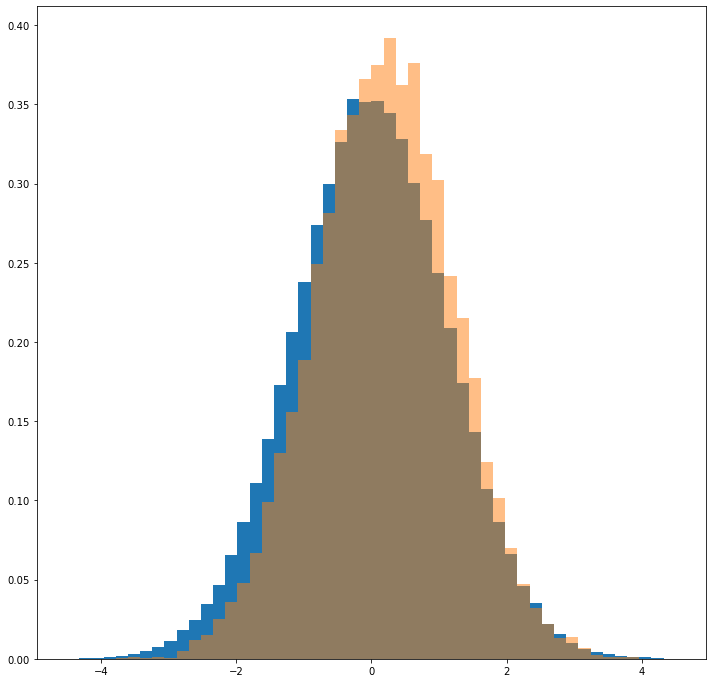

In [143]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

hxmin = -4.5
hxmax = 4.5

hnbins = 50


axi = ax

hist_data_train_det = axi.hist( train_det_pts[:,0], 
                               bins=hnbins, range=[hxmin,hxmax], density=True )

hist_data_true_det = axi.hist( true_det_pts[:,0], 
                              bins=hnbins, range=[hxmin,hxmax], density=True, alpha=0.5 )


plt.show

In [144]:
hist_prob_true = hist_data_true_det[0] / ( hist_data_true_det[0] + hist_data_train_det[0] )

In [145]:
nbins = len(hist_data_true_det[0])
xvals = np.zeros(nbins)
for bi in range(nbins) :
    xvals[bi] = 0.5 * (hist_data_true_det[1][bi] + hist_data_true_det[1][bi+1])

<function matplotlib.pyplot.show(close=None, block=None)>

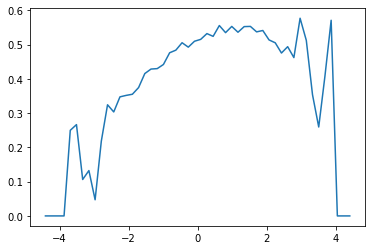

In [146]:
plt.plot(xvals,hist_prob_true)
plt.show

number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


<function matplotlib.pyplot.show(close=None, block=None)>

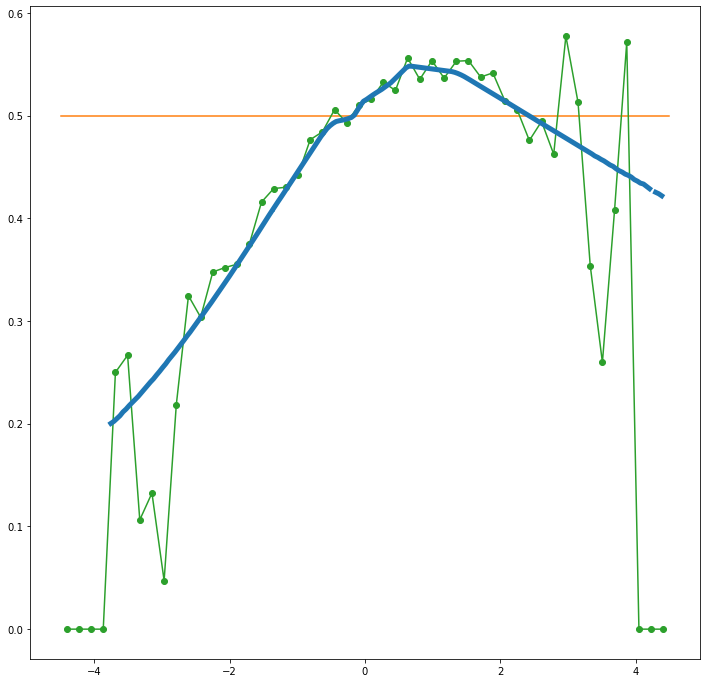

In [147]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

axi = ax
ofi = 0

profile2d( axi, train_det_pts[:,0], of_prob[ofi,0,:], 
          hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
axi.plot([xmin,xmax],[0.5,0.5])
axi.plot(xvals,hist_prob_true,marker='o')
    
plt.show

In [148]:

weights_a = np.ones( len(train_det_pts[:,0]) )
weights_b = np.ones( len(true_det_pts[:,0]) )

rd = prob_from_hists( train_det_pts[:,0], 
                     true_det_pts[:,0], 
                     weights_a, 
                     weights_b, 
                     hnbins, hxmin, hxmax )

<ErrorbarContainer object of 3 artists>

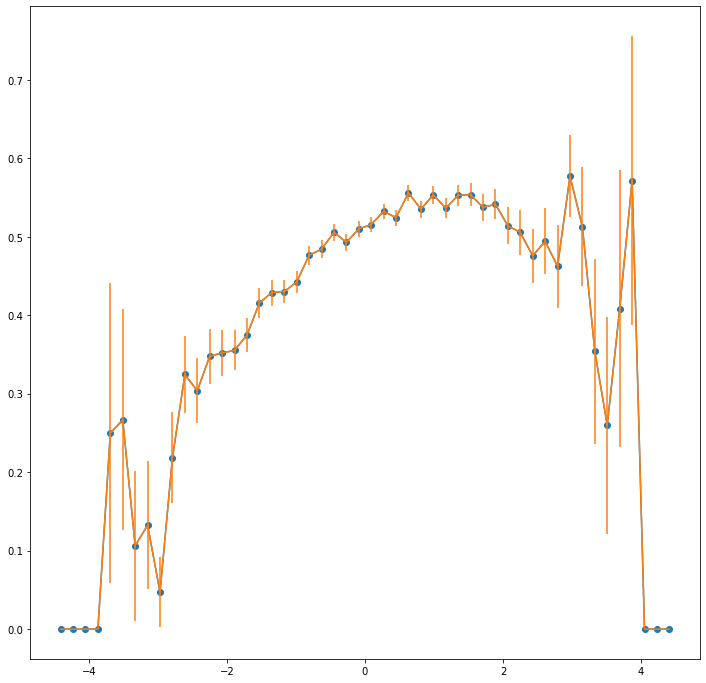

In [149]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

axi = ax

ax.plot(xvals,hist_prob_true,marker='o')
ax.errorbar(xvals,rd['hist_ratio'],rd['hist_ratio_err'])

<function matplotlib.pyplot.show(close=None, block=None)>

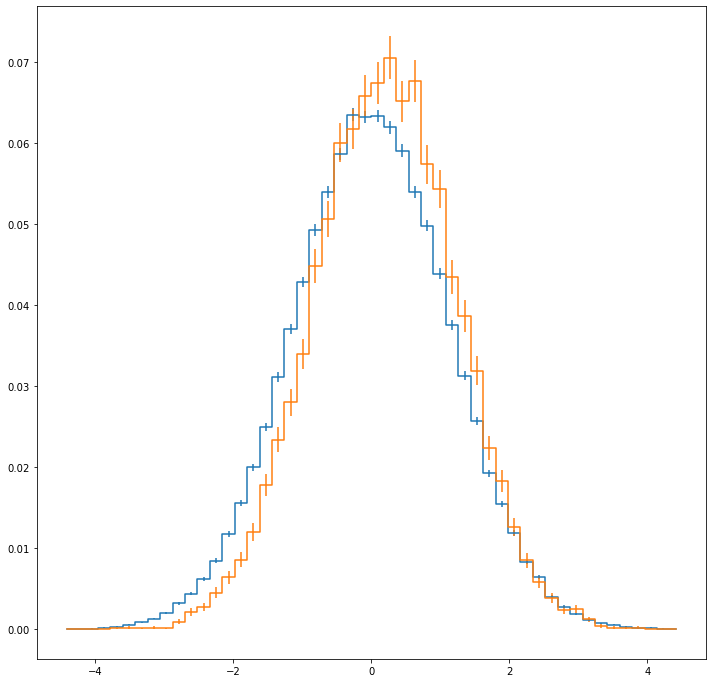

In [157]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

axi = ax

ax.errorbar( xvals, rd['hist_binsum_a'], rd['hist_err_a'], drawstyle='steps-mid')
ax.errorbar( xvals, rd['hist_binsum_b'], rd['hist_err_b'], drawstyle='steps-mid')

plt.show

number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


<ErrorbarContainer object of 3 artists>

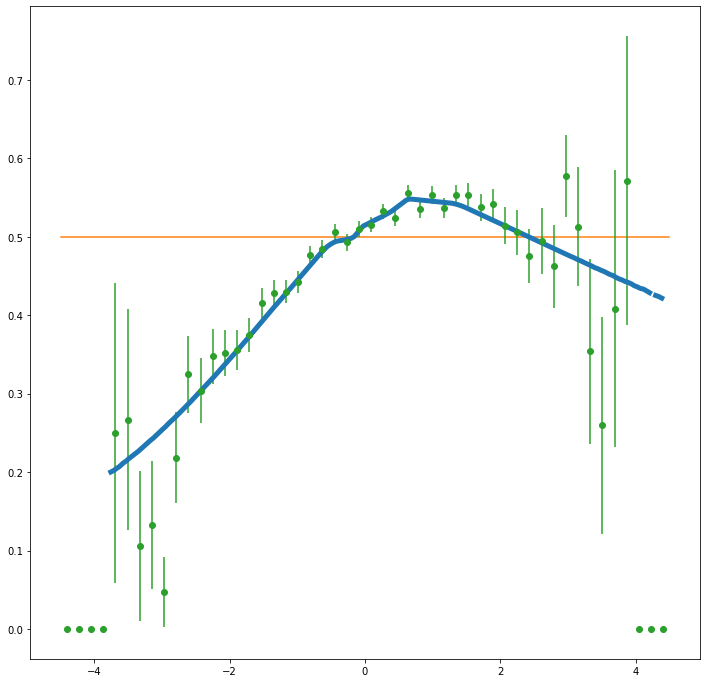

In [158]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

axi = ax
profile2d( axi, train_det_pts[:,0], of_prob[ofi,0,:], 
          hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
axi.plot([xmin,xmax],[0.5,0.5])
ax.errorbar(xvals,rd['hist_ratio'],rd['hist_ratio_err'], marker='o', linestyle='')

In [75]:
of_return_dict['push_weights'][0]

array([0.80850685, 0.68090057, 0.79793012, ..., 1.15113616, 1.15501332,
       1.15289807])

In [76]:
of_return_dict['weights'][0,0,:]

array([0.81307095, 0.78900868, 0.62856501, ..., 1.13148081, 1.19427013,
       1.1221329 ])

In [77]:
of_return_dict['weights'][0,1,:]

array([0.80850685, 0.68090057, 0.79793012, ..., 1.15113616, 1.15501332,
       1.15289807])

## Compare Iteration 0, Step 2 function with function from histograms.

<function matplotlib.pyplot.show(close=None, block=None)>

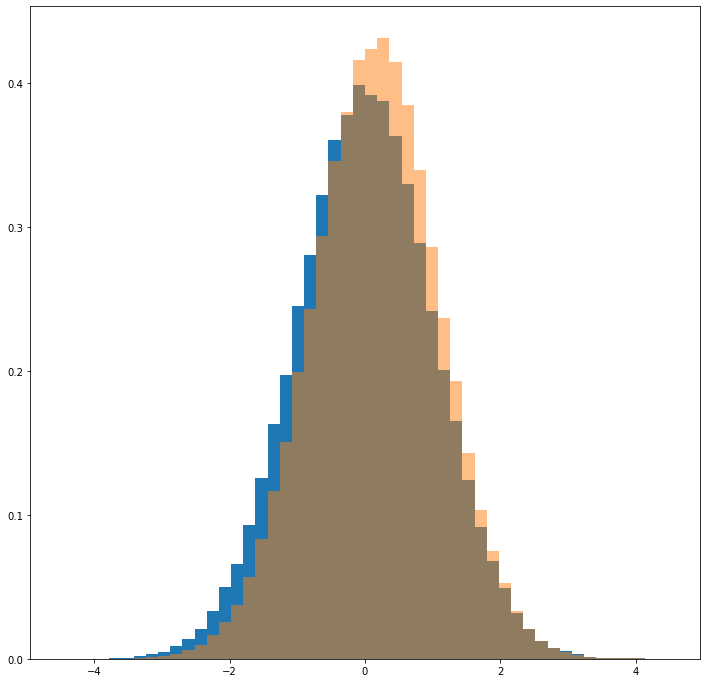

In [78]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

xmin = -4.5
xmax = 4.5


axi = ax

hist_data_train = axi.hist( train_pts[:,0], 
                           bins=50, range=[xmin,xmax], density=True )


#-- this looks wrong but makes a curve that agrees exactly with the NN output...
#hist_data_train_pw = axi.hist( train_pts[:,0], weights=of_return_dict['push_weights'][0],
#                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )
#-- It is wrong, because it's a tautology.


#-- this looks right, but doesn't agree with NN output
hist_data_train_pw = axi.hist( train_pts[:,0], weights=of_return_dict['weights'][0,0,:],
                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )


plt.show

In [79]:
hist_prob_pw = hist_data_train_pw[0] / ( hist_data_train_pw[0] + hist_data_train[0] )

/tmp/ipykernel_3575845/2552467821.py:1: RuntimeWarning: invalid value encountered in divide
  hist_prob_pw = hist_data_train_pw[0] / ( hist_data_train_pw[0] + hist_data_train[0] )


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


<function matplotlib.pyplot.show(close=None, block=None)>

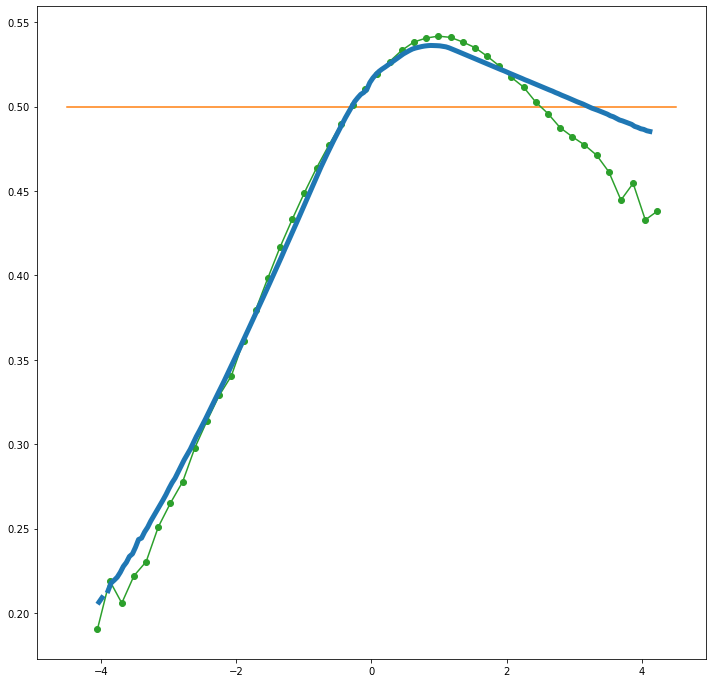

In [80]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

axi = ax
ofi = 0


profile2d( axi, train_pts[:,0], of_prob[ofi,1,:], 
          hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 

axi.plot([xmin,xmax],[0.5,0.5])
axi.plot(xvals,hist_prob_pw,marker='o')
    
plt.show

## Iteration 1, Step 1

In [81]:
of_return_dict['push_weights']

array([[0.80850685, 0.68090057, 0.79793012, ..., 1.15113616, 1.15501332,
        1.15289807],
       [0.76980745, 0.6116005 , 0.75638431, ..., 1.21049936, 1.20943339,
        1.2041406 ],
       [0.77425261, 0.60460782, 0.76008553, ..., 1.23686549, 1.23314251,
        1.22719374],
       [0.77544528, 0.59621816, 0.76068346, ..., 1.24683932, 1.23690914,
        1.22963376],
       [0.78471122, 0.59862432, 0.76953451, ..., 1.26268275, 1.24918931,
        1.24110408]])

<function matplotlib.pyplot.show(close=None, block=None)>

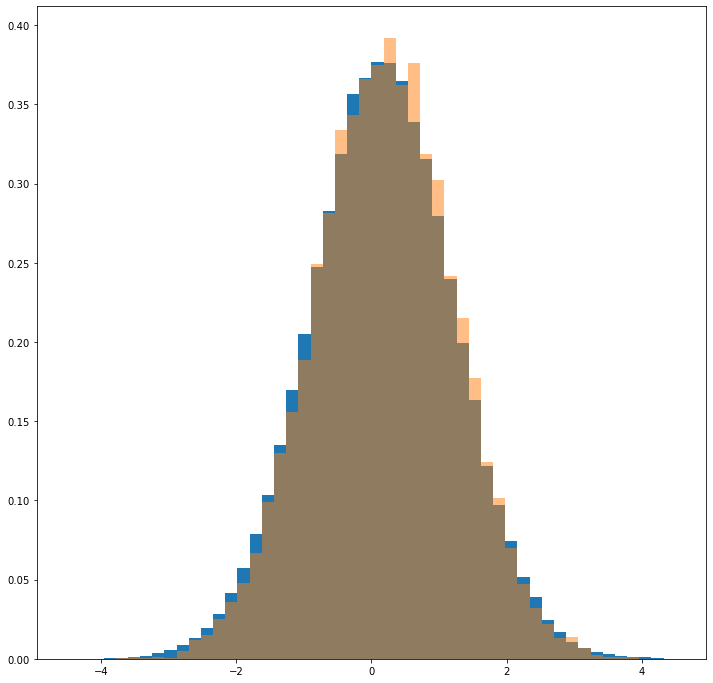

In [82]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

xmin = -4.5
xmax = 4.5

ofi=1

axi = ax

hist_data_train_det = axi.hist( train_det_pts[:,0], weights=of_return_dict['push_weights'][ofi-1],
                               bins=50, range=[xmin,xmax], density=True )

hist_data_true_det = axi.hist( true_det_pts[:,0], 
                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )


plt.show

In [83]:
hist_prob_true = hist_data_true_det[0] / ( hist_data_true_det[0] + hist_data_train_det[0] )

number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


<function matplotlib.pyplot.show(close=None, block=None)>

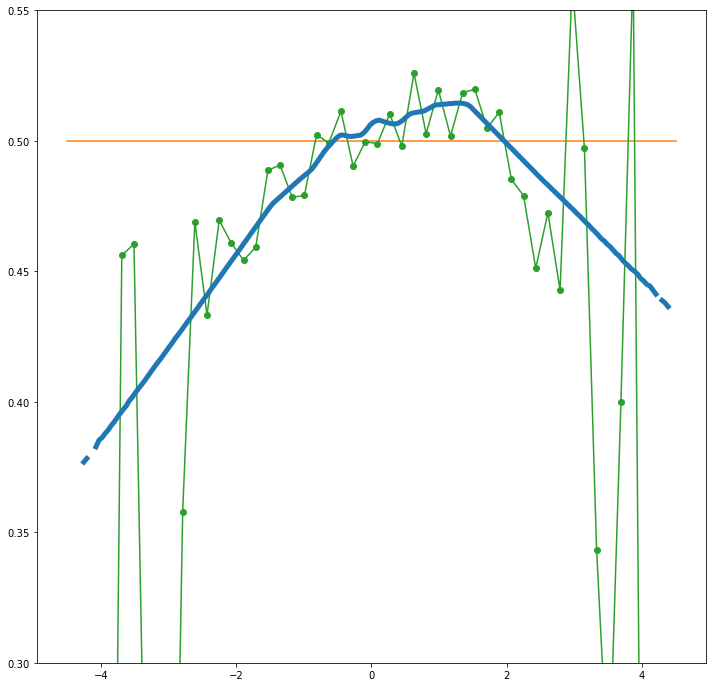

In [84]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

axi = ax
ofi = 1

profile2d( axi, train_det_pts[:,0], of_prob[ofi,0,:], 
          hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
axi.plot([xmin,xmax],[0.5,0.5])
axi.plot(xvals,hist_prob_true,marker='o')
    
axi.set_ylim([0.30,0.55])

plt.show

## Iteration 1, Step 2

<function matplotlib.pyplot.show(close=None, block=None)>

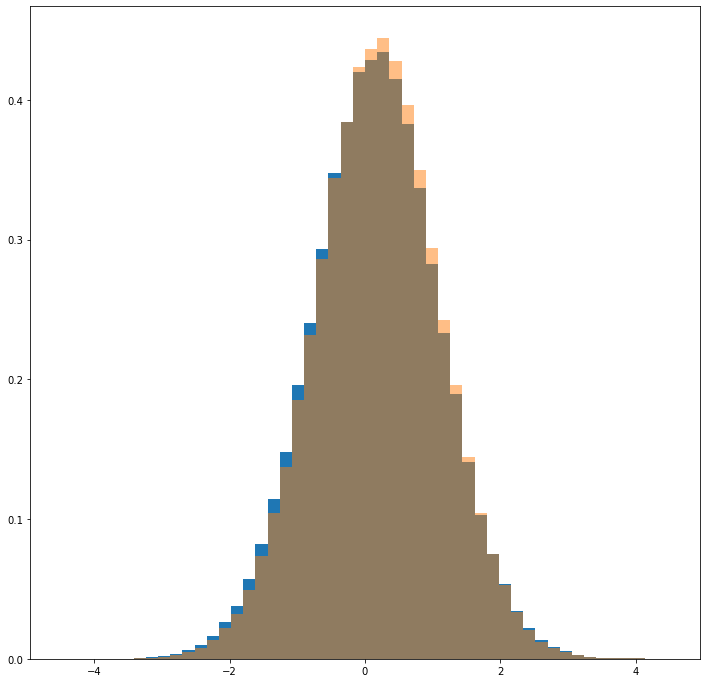

In [85]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

xmin = -4.5
xmax = 4.5

ofi=1

pull_weights = of_return_dict['push_weights'][ofi-1] * of_return_dict['weights'][ofi,0,:]

axi = ax

hist_data_train = axi.hist( train_pts[:,0], weights=of_return_dict['push_weights'][ofi-1],
                           bins=50, range=[xmin,xmax], density=True )

#-- looks wrong but agrees exactly
#hist_data_train_pw = axi.hist( train_pts[:,0], weights=of_return_dict['push_weights'][ofi],
#                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )

#-- looks correct but doesn't agree exactly
hist_data_train_pw = axi.hist( train_pts[:,0], weights=pull_weights,
                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )


plt.show

In [86]:
hist_prob_pw = hist_data_train_pw[0] / ( hist_data_train_pw[0] + hist_data_train[0] )

/tmp/ipykernel_3575845/2552467821.py:1: RuntimeWarning: invalid value encountered in divide
  hist_prob_pw = hist_data_train_pw[0] / ( hist_data_train_pw[0] + hist_data_train[0] )


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


<function matplotlib.pyplot.show(close=None, block=None)>

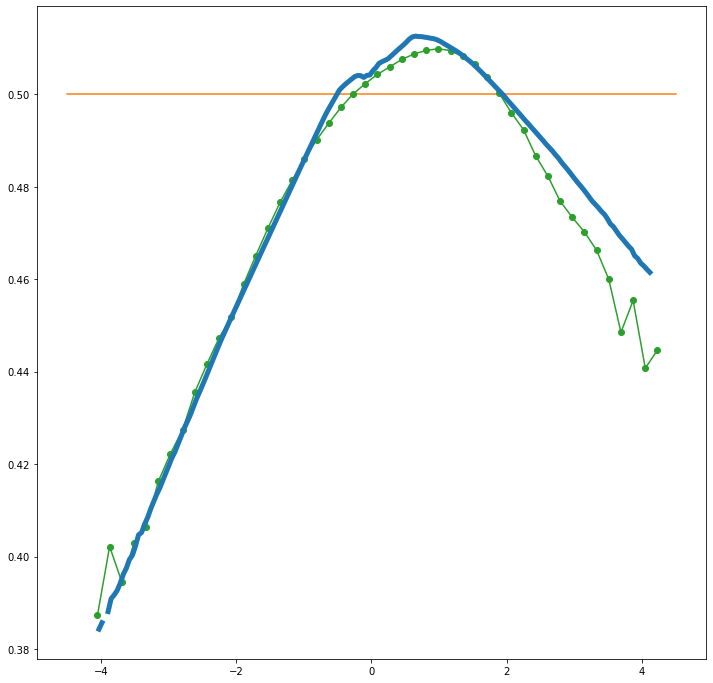

In [87]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

axi = ax
ofi = 1

profile2d( axi, train_pts[:,0], of_prob[ofi,1,:], 
          hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
axi.plot([xmin,xmax],[0.5,0.5])
axi.plot(xvals,hist_prob_pw,marker='o')
    
plt.show

## Iteration 2, Step 1

<function matplotlib.pyplot.show(close=None, block=None)>

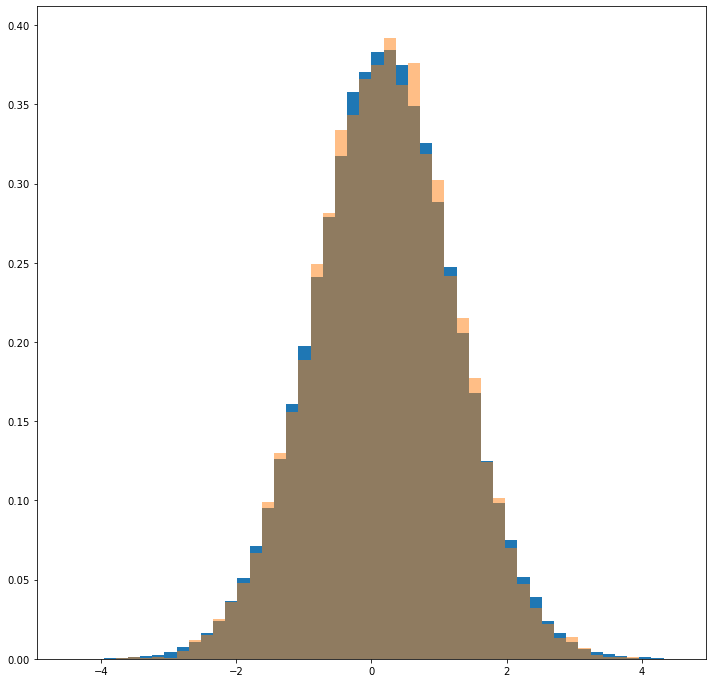

In [88]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

xmin = -4.5
xmax = 4.5

ofi=2

axi = ax

hist_data_train_det = axi.hist( train_det_pts[:,0], weights=of_return_dict['push_weights'][ofi-1],
                               bins=50, range=[xmin,xmax], density=True )

hist_data_true_det = axi.hist( true_det_pts[:,0], 
                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )


plt.show

In [89]:
hist_prob_true = hist_data_true_det[0] / ( hist_data_true_det[0] + hist_data_train_det[0] )

number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


<function matplotlib.pyplot.show(close=None, block=None)>

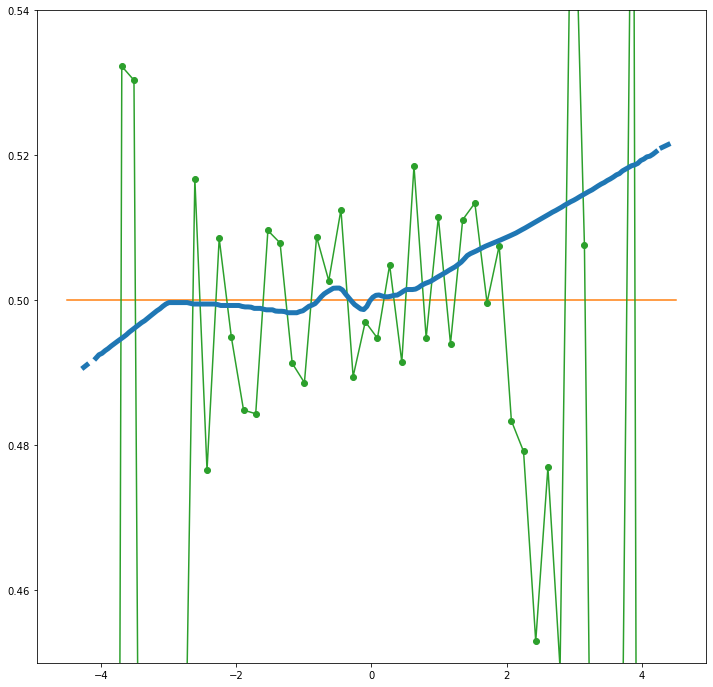

In [90]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

axi = ax
ofi = 2

profile2d( axi, train_det_pts[:,0], of_prob[ofi,0,:], 
          hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
axi.plot([xmin,xmax],[0.5,0.5])
axi.plot(xvals,hist_prob_true,marker='o')

axi.set_ylim([0.45,0.54])
    
plt.show

## Iteration 2, step 2

<function matplotlib.pyplot.show(close=None, block=None)>

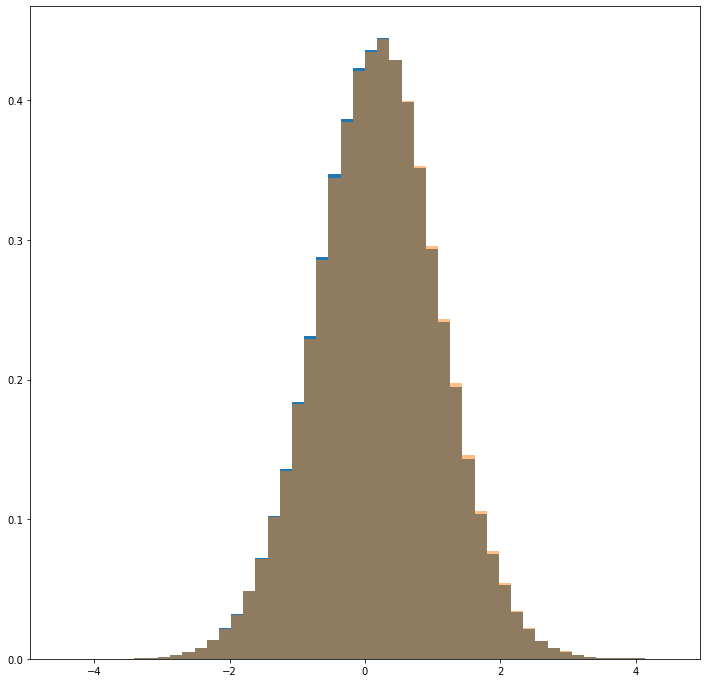

In [91]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

xmin = -4.5
xmax = 4.5

ofi=2


pull_weights = of_return_dict['push_weights'][ofi-1] * of_return_dict['weights'][ofi,0,:]

axi = ax

hist_data_train = axi.hist( train_pts[:,0], weights=of_return_dict['push_weights'][ofi-1],
                           bins=50, range=[xmin,xmax], density=True )

#-- looks wrong but matches well
#hist_data_train_pw = axi.hist( train_pts[:,0], weights=of_return_dict['push_weights'][ofi],
#                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )

#-- looks correct but doesn't match
hist_data_train_pw = axi.hist( train_pts[:,0], weights=pull_weights,
                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )

plt.show

In [92]:
hist_prob_pw = hist_data_train_pw[0] / ( hist_data_train_pw[0] + hist_data_train[0] )

/tmp/ipykernel_3575845/2552467821.py:1: RuntimeWarning: invalid value encountered in divide
  hist_prob_pw = hist_data_train_pw[0] / ( hist_data_train_pw[0] + hist_data_train[0] )


In [93]:
np.sum(hist_data_train_pw[0])

5.555555555555556

In [94]:
np.sum(hist_data_train[0])

5.555555555555556

/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


<function matplotlib.pyplot.show(close=None, block=None)>

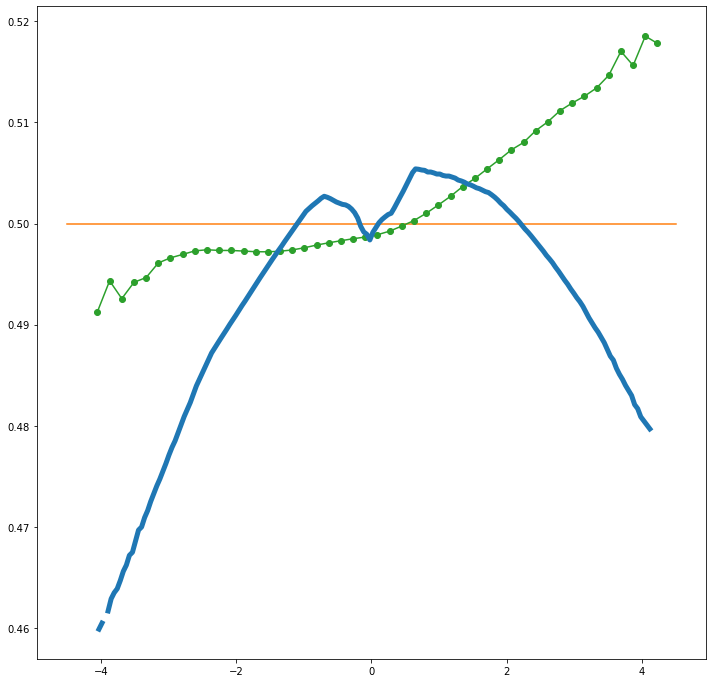

In [95]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

axi = ax
ofi = 2

profile2d( axi, train_pts[:,0], of_prob[ofi,1,:], 
          hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
axi.plot([xmin,xmax],[0.5,0.5])
axi.plot(xvals,hist_prob_pw,marker='o')
    
plt.show

## Iteration 3, Step 1

<function matplotlib.pyplot.show(close=None, block=None)>

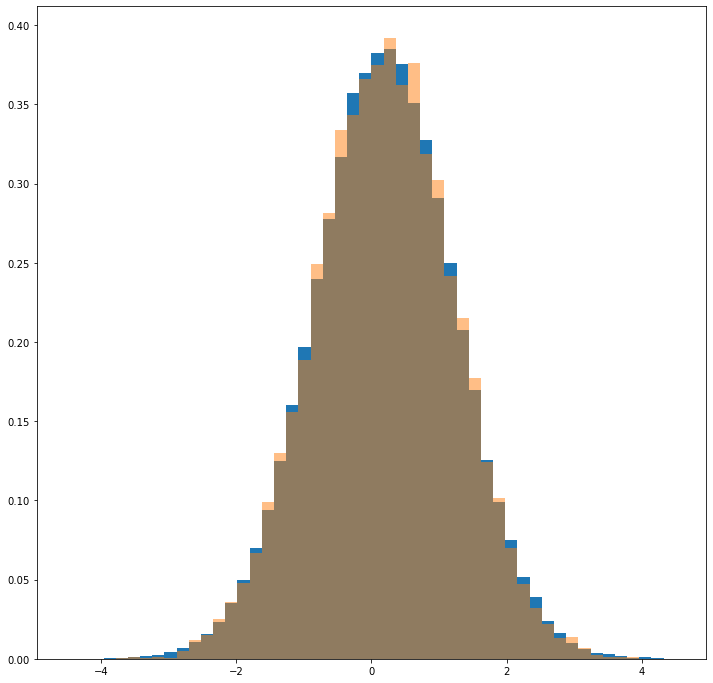

In [96]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

xmin = -4.5
xmax = 4.5


axi = ax

hist_data_train_det = axi.hist( train_det_pts[:,0], weights=of_return_dict['push_weights'][2],
                               bins=50, range=[xmin,xmax], density=True )

hist_data_true_det = axi.hist( true_det_pts[:,0], 
                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )


plt.show

In [97]:
hist_prob_true = hist_data_true_det[0] / ( hist_data_true_det[0] + hist_data_train_det[0] )

number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


<function matplotlib.pyplot.show(close=None, block=None)>

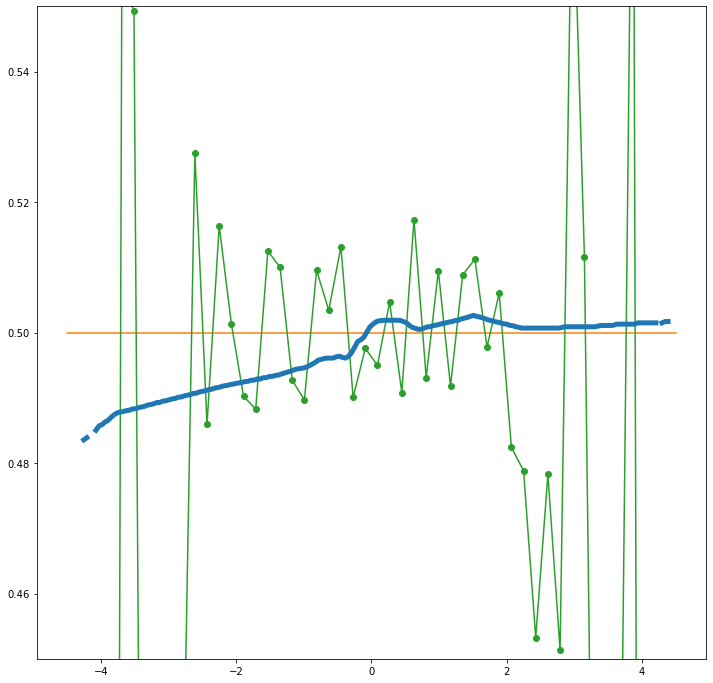

In [98]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

axi = ax
ofi = 3

profile2d( axi, train_det_pts[:,0], of_prob[ofi,0,:], 
          hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
axi.plot([xmin,xmax],[0.5,0.5])
axi.plot(xvals,hist_prob_true,marker='o')

axi.set_ylim([0.45,0.55])
    
plt.show

## Iteration 3, Step 2

<function matplotlib.pyplot.show(close=None, block=None)>

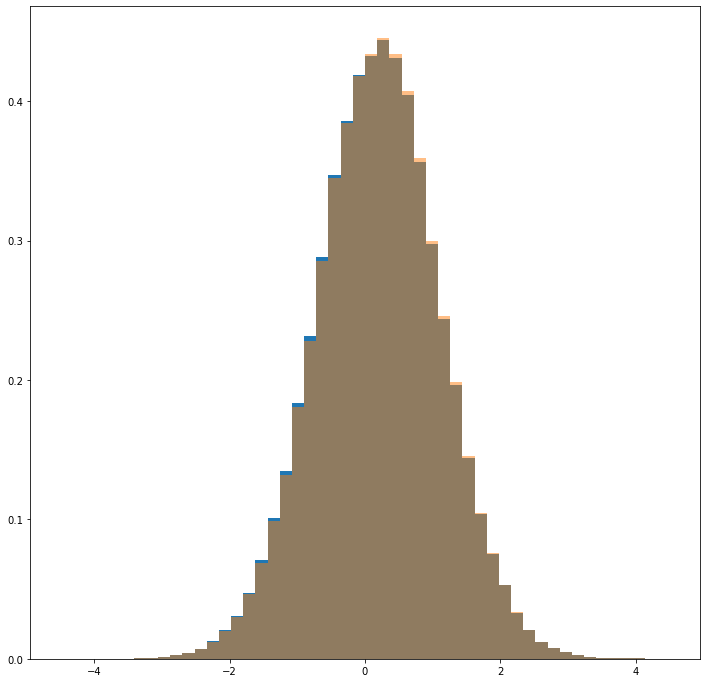

In [99]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

xmin = -4.5
xmax = 4.5

ofi=3


pull_weights = of_return_dict['push_weights'][ofi-1] * of_return_dict['weights'][ofi,0,:]

axi = ax

hist_data_train = axi.hist( train_pts[:,0], weights=of_return_dict['push_weights'][ofi-1],
                           bins=50, range=[xmin,xmax], density=True )

#-- looks wrong but matches well
#hist_data_train_pw = axi.hist( train_pts[:,0], weights=of_return_dict['push_weights'][ofi],
#                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )

#-- looks correct but doesn't match
hist_data_train_pw = axi.hist( train_pts[:,0], weights=pull_weights,
                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )

plt.show

In [100]:
hist_prob_pw = hist_data_train_pw[0] / ( hist_data_train_pw[0] + hist_data_train[0] )

/tmp/ipykernel_3575845/2552467821.py:1: RuntimeWarning: invalid value encountered in divide
  hist_prob_pw = hist_data_train_pw[0] / ( hist_data_train_pw[0] + hist_data_train[0] )


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


<function matplotlib.pyplot.show(close=None, block=None)>

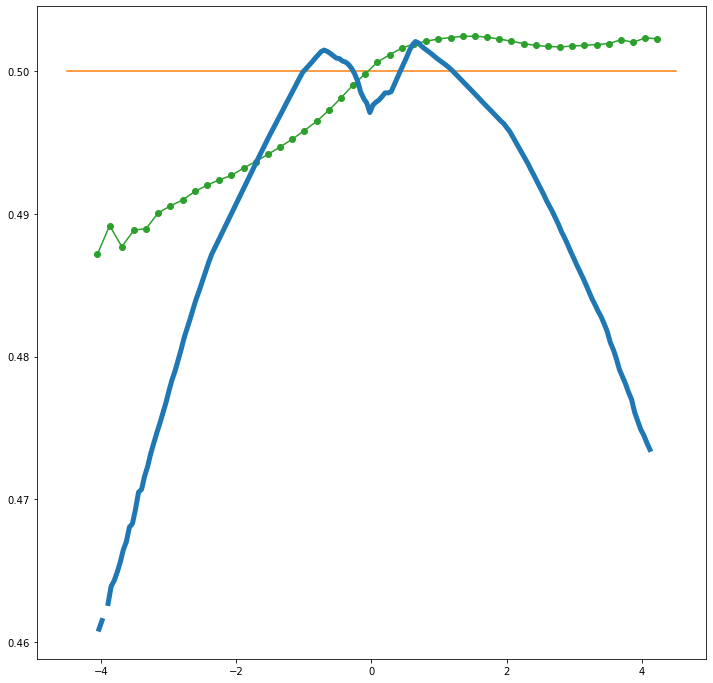

In [101]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

axi = ax
ofi = 3

profile2d( axi, train_pts[:,0], of_prob[ofi,1,:], 
          hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
axi.plot([xmin,xmax],[0.5,0.5])
axi.plot(xvals,hist_prob_pw,marker='o')
    
plt.show

## Iteration 4, Step 1

<function matplotlib.pyplot.show(close=None, block=None)>

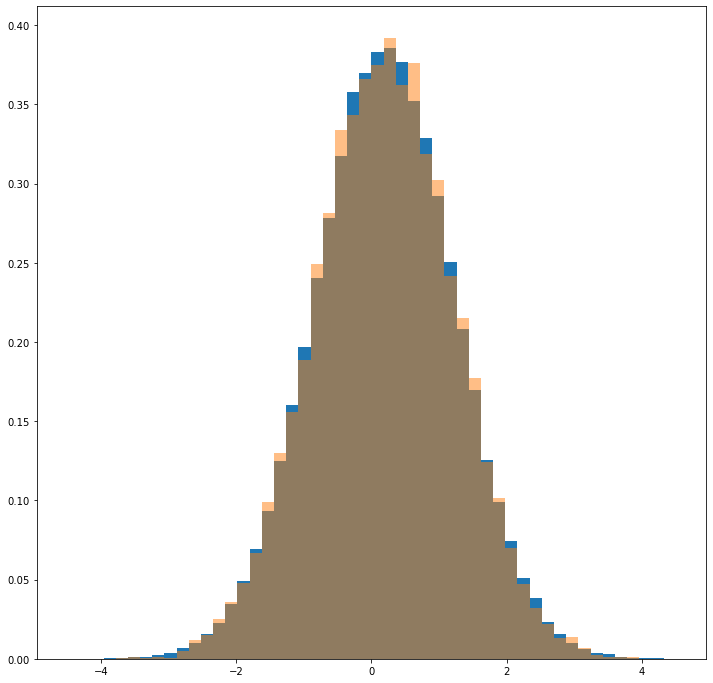

In [102]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

xmin = -4.5
xmax = 4.5

ofi=4

axi = ax

hist_data_train_det = axi.hist( train_det_pts[:,0], weights=of_return_dict['push_weights'][ofi-1],
                               bins=50, range=[xmin,xmax], density=True )

hist_data_true_det = axi.hist( true_det_pts[:,0], 
                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )


plt.show

In [103]:
hist_prob_true = hist_data_true_det[0] / ( hist_data_true_det[0] + hist_data_train_det[0] )

number of y bins: 2000
number of x bins: 200


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


<function matplotlib.pyplot.show(close=None, block=None)>

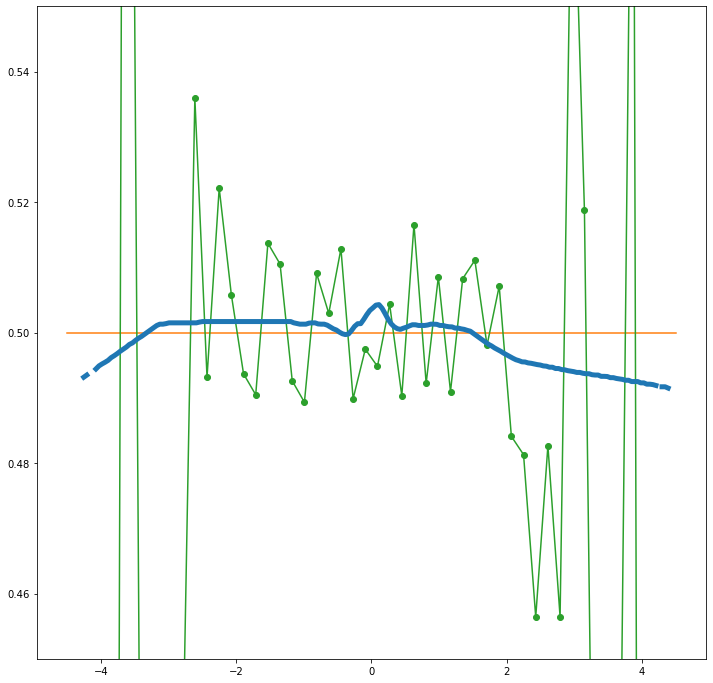

In [104]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

axi = ax
ofi = 4

profile2d( axi, train_det_pts[:,0], of_prob[ofi,0,:], 
          hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
axi.plot([xmin,xmax],[0.5,0.5])
axi.plot(xvals,hist_prob_true,marker='o')

axi.set_ylim([0.45,0.55])
    
plt.show

## Iteration 4, Step 2

<function matplotlib.pyplot.show(close=None, block=None)>

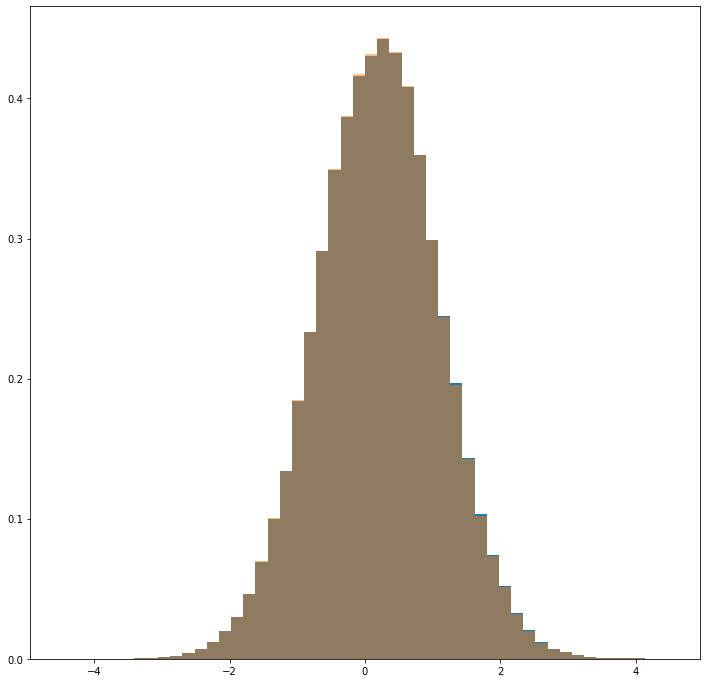

In [105]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

xmin = -4.5
xmax = 4.5

ofi=4


pull_weights = of_return_dict['push_weights'][ofi-1] * of_return_dict['weights'][ofi,0,:]

axi = ax

hist_data_train = axi.hist( train_pts[:,0], weights=of_return_dict['push_weights'][ofi-1],
                           bins=50, range=[xmin,xmax], density=True )

#-- looks wrong but matches well
#hist_data_train_pw = axi.hist( train_pts[:,0], weights=of_return_dict['push_weights'][ofi],
#                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )

#-- looks correct but doesn't match
hist_data_train_pw = axi.hist( train_pts[:,0], weights=pull_weights,
                              bins=50, range=[xmin,xmax], density=True, alpha=0.5 )

plt.show

In [106]:
hist_prob_pw = hist_data_train_pw[0] / ( hist_data_train_pw[0] + hist_data_train[0] )

/tmp/ipykernel_3575845/2552467821.py:1: RuntimeWarning: invalid value encountered in divide
  hist_prob_pw = hist_data_train_pw[0] / ( hist_data_train_pw[0] + hist_data_train[0] )


/tmp/ipykernel_3575845/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3575845/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 2000
number of x bins: 200


<function matplotlib.pyplot.show(close=None, block=None)>

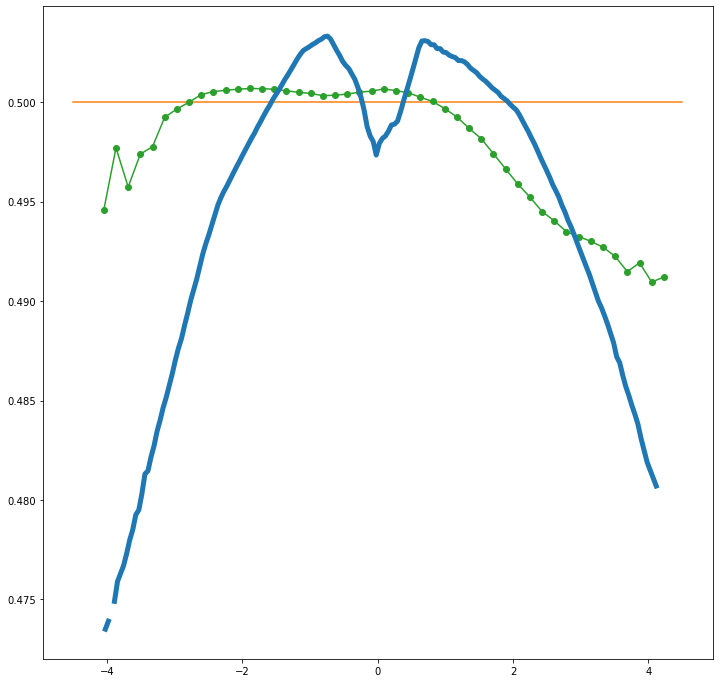

In [107]:
fig,ax = plt.subplots( 1, 1, figsize=(1*12,1*12))

axi = ax
ofi = 4

profile2d( axi, train_pts[:,0], of_prob[ofi,1,:], 
          hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
axi.plot([xmin,xmax],[0.5,0.5])
axi.plot(xvals,hist_prob_pw,marker='o')
    
plt.show